In [ ]:
#Importando las librerias necesarias
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import random
import itertools
#----------------
import sys
#----------------
import time

import os



---
##removeBack_clipped_balanced

---



Traatando de concontrar los mejores modelos


---

SCIKITMAAD




In [ ]:
# Check nvidia and nvcc cuda compiler

!nvidia-smi
!/usr/local/cuda/bin/nvcc --version
#import os
#from tensorflow.python.profiler import profiler_client

#tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
#print(profiler_client.monitor(tpu_profile_service_address, 100, 2))

Mon Mar 27 19:20:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1.- GET DATA
---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Loading the dataset: birdsBolivia

---



In [ ]:
# El dataset es cargado en DRIVE, se definen los directorios de lectura de los archivos de audio y escritura de los espectogramas generados
# Previamente debe estar montada la unidad de drive en colab
WAVES_DIR       = '/content/drive/MyDrive/Thesis/DataSets/BirdsBolivia/audio/recordings_clipped/'  #'/content/drive/MyDrive/Thesis/test/'
#spectrogramas scikit maad
SPECTOGRAMS_DIR = '/content/drive/MyDrive/Thesis/DataSets/BirdsBolivia/images/spect_clipped_removeback_balanced/'
#SPECTOGRAMS_DIR = '/content/drive/My Drive/DataSets/FreeSpokenDigitDataset/spectrograms_pylab/'


In [ ]:
#cargando el listado de archivos de audio
waves = os.listdir(WAVES_DIR)
#sampling_rate: frecuencia de muestreo es el número de esas muestras del audio que hay en un 1 segundo.
# 44100 es un standar basado en la teoria de Nyquist
# 22050  tambien es aceptable aunque se perderian algunas frecuencias altas, es el mas usado 
#sampling_rate = 22050
waves

['2', '3', '4', '5', '6', '8', '9', '10', '1', '7']

##Print all the classes/categories that we have for the target

---



In [ ]:
import os
print('root:'+SPECTOGRAMS_DIR)
for root, dirs, files in os.walk(SPECTOGRAMS_DIR, topdown=False):   
   #for name in files:
      #print(os.path.join(root, name))       
   for name in dirs:
      #print(os.path.join(root, name)) 
      #print('Clase: '+ name)
      initial_count = 0
      dir = os.path.join(root, name)
      for path in os.listdir(dir):
        if os.path.isfile(os.path.join(dir, path)):
          initial_count += 1
      print('Clase: '+ name+' ; '+'Qty files:'+str(initial_count))


root:/content/drive/MyDrive/Thesis/DataSets/BirdsBolivia/images/spect_clipped_removeback_balanced/
Clase: bird2 ; Qty files:300
Clase: bird1 ; Qty files:300
Clase: bird3 ; Qty files:300
Clase: bird4 ; Qty files:300
Clase: bird5 ; Qty files:300
Clase: bird6 ; Qty files:300
Clase: bird8 ; Qty files:300
Clase: bird9 ; Qty files:300
Clase: bird10 ; Qty files:300
Clase: bird7 ; Qty files:300


#Preparing the data

---
Vamos a usar TensorFlow para generar un tf.data.Dataset a partir de archivos de imagen en un directorio.
TensorFlow es un paquete de DeepLearning desarrollado y de código abierto por Google.

Luego, llamar a image_dataset_from_directory(main_directory, labels='inferred') devolverá un tf.data.Dataset que produce lotes de imágenes de los subdirectorios class_a y class_b, etc , junto con las etiquetas 0 y 1 , etc. (0 correspondiente a class_a y 1 correspondiente a class_b ).

Formatos de imagen soportados:jpeg,png,bmp,gif.Los gifs animados se truncan hasta el primer fotograma

Ahora podemos cargar los espectrogramas en la memoria. Usamos la utilidad image_dataset_from_directory para generar los conjuntos de datos, y usamos las capas de preprocesamiento de imágenes de Keras para la estandarización de imágenes y el aumento de datos. El conjunto de validación es lo que en última instancia será nuestro punto de referencia cuando se trata del rendimiento y la precisión de nuestro clasificador. El tamaño del lote es bastante bajo por ahora (32) para que todas las imágenes quepan en la memoria. La semilla es para la reproducibilidad.

More information:

https://keras.io/examples/vision/image_classification_from_scratch/
https://runebook.dev/es/docs/tensorflow/keras/preprocessing/image_dataset_from_directory
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
# Declare constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
NO_CHANNELS = 3
###################################################
# PARAMETRIZAR  NRO CLASES
###################################################
NO_CLASSES = 10
###################################################
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, NO_CHANNELS)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                          directory=SPECTOGRAMS_DIR,#Directorio raiz
                          labels='inferred',#si se utiliza inferred produce lotes de imágenes de los subdirectorios, cada debe existir un directorio por cada clase 
                          label_mode='int', # va a codificar el label  como labelEncode  1 2 3 etc # 'categorical' codifica como  one hot encode
                          image_size=(IMAGE_HEIGHT, IMAGE_WIDTH), #Tamaño para cambiar el tamaño de las imágenes después de leerlas del disco
                          interpolation='bilinear', #el método de interpolación utilizado al cambiar el tamaño de las imágenes. El valor predeterminado es bilineal.
                          batch_size=32, # Tamaño de  los lotes de datos, es decir va a tomar cada 32 registros
                          shuffle=True, # Para mezclar los datos
                          color_mode='rgb',# Para determinar cuantos canales va a tener la imagen "grayscale", "rgb", "rgba"
                          validation_split=0.2,# Fraccion de datos que se va a reservar para validacion
                          subset="training", # Solo se usa si el validation_split esta configurado, especifica que dataset va a retornar  
                          seed=0
                          )
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                          directory=SPECTOGRAMS_DIR, # directorio raiz
                          labels='inferred', #   
                          label_mode='int',  #
                          image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                          interpolation='bilinear',
                          batch_size=32,
                          shuffle=True,
                          color_mode='rgb',
                          validation_split=0.2,
                          subset="validation",
                          seed=0
                          )

Found 3000 files belonging to 10 classes.
Using 2400 files for training.
Found 3000 files belonging to 10 classes.
Using 600 files for validation.


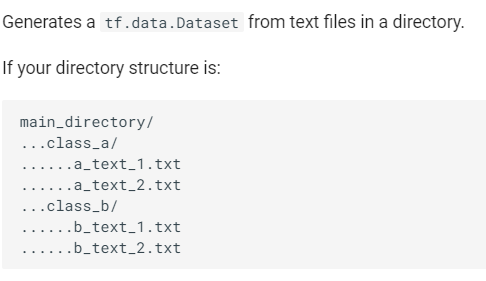

In [ ]:
train_dataset.class_names

['bird1',
 'bird10',
 'bird2',
 'bird3',
 'bird4',
 'bird5',
 'bird6',
 'bird7',
 'bird8',
 'bird9']

#Reviewing a little the dataser generated

---



In [ ]:
train_dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
#ds_train_.take(1)

In [ ]:
### se puede ver el tensor de 32
## Cada registro representa una etiqueta, como se ha utilizado label mode=int, cada categoria esta  codificada como label encode numero en la misma columna
## es posible cambiar esto usando "categorial" en ese caso se geneera un tensor de 32, donde cada item es un array a suvez en codificacion one hote
for images, labels in train_dataset.take(1):
    print(labels)
   

tf.Tensor([1 7 6 3 7 2 9 5 9 6 5 5 0 6 9 8 9 6 1 2 9 0 3 5 3 1 7 3 3 7 2 7], shape=(32,), dtype=int32)


In [ ]:
### revisando la data, vemos que las imagenes estan como tensores
for images, labels in train_dataset.take(1):
    print(images)

tf.Tensor(
[[[[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  ...

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]]


 [[[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 2

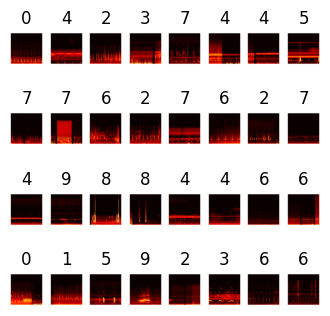

In [ ]:
### ploteando las imagenes desde los arreglos, el primer bacth de 32
plt.figure(figsize=(4, 4))
for images, labels in train_dataset.take(1):
    for i in range(32): 
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")    
plt.show()

#Scaling

---
I applied a rescaling the data input from the (0, 255) range to be in the (0,1) range.

In [ ]:
rescale = Rescaling(scale=1.0/255)
train_esc = train_dataset.map(lambda image,label:(rescale(image),label))
valid_esc  = valid_dataset.map(lambda image,label:(rescale(image),label))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


#MODELING

---



In [ ]:
!pip install pad_sequences
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.layers import Dense, Softmax, Dropout

In [ ]:
from keras.callbacks import ModelCheckpoint
#from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GRU
from keras.layers import Activation, Dropout, Flatten, Dense, TimeDistributed

In [ ]:
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, NO_CHANNELS)

In [ ]:
#NO_CLASSES = 10

# Model#1 : CNN1-DROPOUT

---



In [ ]:
# Create CNN model #1 
#las capas convolucinales extraen features de las imagenes
# las unidades de las redes neuronales se definen  con pequeños valores, por que cuando usamos 256 ,128,64  kicks ERROR :(  problemas de memoria
cnn1 = Sequential()
cnn1.add(Conv2D(16,kernel_size=(3, 3),activation="relu", padding='valid' ,input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NO_CHANNELS)))
cnn1.add(MaxPooling2D((2, 2), strides=2))
cnn1.add(Dropout(0.5))
cnn1.add(Conv2D(32, kernel_size=(3, 3),activation="relu", padding='valid' ))
cnn1.add(MaxPooling2D((2, 2),strides=2))
cnn1.add(Dropout(0.5))
cnn1.add(Conv2D(64, kernel_size=(3, 3),activation="relu", padding='valid' ))
cnn1.add(MaxPooling2D((2, 2),strides=2))
cnn1.add(Dropout(0.5))
cnn1.add(Conv2D(128, kernel_size=(3, 3),activation="relu", padding='valid' ))
cnn1.add(MaxPooling2D((2, 2),strides=2))
cnn1.add(Dropout(0.5))
#capa de clasisficacion
cnn1.add(Flatten())
cnn1.add(Dense(32,activation="relu"))
cnn1.add(Dense(NO_CLASSES, activation="softmax"))

cnn1.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_136 (Conv2D)         (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 dropout_36 (Dropout)        (None, 127, 127, 16)      0         
                                                                 
 conv2d_137 (Conv2D)         (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 dropout_37 (Dropout)        (None, 62, 62, 32)      

In [ ]:
# Compile model
cnn1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

In [ ]:
import time
start1 = time.time()
# Train model for 10 epochs, capture the history
cnn1_hist = cnn1.fit(train_esc, epochs=75, validation_data=valid_esc)
end1 = time.time()
cnn1_time = end1-start1
print("CNN #1 Time: {:0.2f} minute".format(cnn1_time/60.0))

Epoch 1/75
75/75 [==============================] - 5s 31ms/step - loss: 2.2949 - accuracy: 0.1154 - val_loss: 2.2925 - val_accuracy: 0.1733
Epoch 2/75
75/75 [==============================] - 3s 34ms/step - loss: 2.1699 - accuracy: 0.1917 - val_loss: 2.1093 - val_accuracy: 0.2450
Epoch 3/75
75/75 [==============================] - 3s 35ms/step - loss: 1.8469 - accuracy: 0.3233 - val_loss: 1.8270 - val_accuracy: 0.3550
Epoch 4/75
75/75 [==============================] - 3s 35ms/step - loss: 1.5375 - accuracy: 0.4187 - val_loss: 1.5113 - val_accuracy: 0.4133
Epoch 5/75
75/75 [==============================] - 3s 34ms/step - loss: 1.3004 - accuracy: 0.4825 - val_loss: 1.3174 - val_accuracy: 0.4917
Epoch 6/75
75/75 [==============================] - 3s 34ms/step - loss: 1.1385 - accuracy: 0.5117 - val_loss: 1.1931 - val_accuracy: 0.5217
Epoch 7/75
75/75 [==============================] - 3s 34ms/step - loss: 1.0254 - accuracy: 0.5813 - val_loss: 1.0713 - val_accuracy: 0.5617
Epoch 8/75
75

 ***** Generating evaluation metrics CNN1 ****
 
 Asignamos los resultados de model.fit a un objeto history. Esto nos permitirá ver los resultados de las pruebas

In [ ]:
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# es necesario que el  predict y el ytest esten en el mismo for, con eso garantizamos que ambos trabajen con el mismo conjunto de datos
from sklearn.metrics import confusion_matrix
from sklearn import metrics
yPred = np.array([])
yTest =  np.array([])
for x, y in valid_esc:
  yPred = np.concatenate([yPred, np.argmax(cnn1.predict(x), axis = -1)])
  yTest = np.concatenate([yTest, y.numpy()])  # no es necesario el argmax  aqui np.argmax(y.numpy(), axis=-1)

1/1 [==============================] - 0s 104ms/step


In [ ]:
cnn_f1 = metrics.f1_score(yTest, yPred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(yTest, yPred)
cnn_precision = metrics.precision_score(yTest, yPred,average="micro" )
cnn_recall = metrics.recall_score (yTest, yPred,average="micro" )
print("--------------------------------------------")
print("-----------------CNN1 Summary---------------")
print("--------------------------------------------")
print("CNN1 Time: {:0.2f} minute".format(cnn1_time/60.0))
print("F1 score: {}".format(cnn_f1))
print("Accuracy score: {}".format(cnn_accuracy))
print("Precision score: {}".format(cnn_precision))
print("Recall score: {}".format(cnn_recall))


--------------------------------------------
-----------------CNN1 Summary---------------
--------------------------------------------
CNN1 Time: 3.61 minute
F1 score: 0.5922267271649352
Accuracy score: 0.615
Precision score: 0.615
Recall score: 0.615


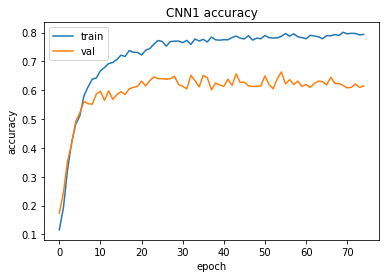

In [ ]:
##---------------------------------------------
##-------------- Accuracy evolution -----------
##---------------------------------------------
from matplotlib import pyplot as plt
plt.plot(cnn1_hist.history['accuracy'])
plt.plot(cnn1_hist.history['val_accuracy'])
plt.title('CNN1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

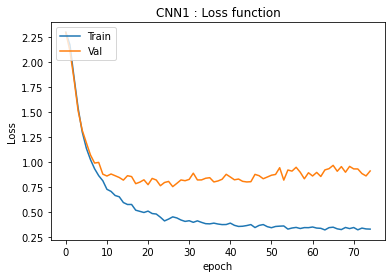

In [ ]:
##---------------------------------------------
##-------------- Loss evolution -----------
##---------------------------------------------
from matplotlib import pyplot as plt
plt.plot(cnn1_hist.history['loss'])
plt.plot(cnn1_hist.history['val_loss'])
plt.title('CNN1 : Loss function')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

-------------------------------------------
--------- Plotting confusion matrix--------
-------------------------------------------


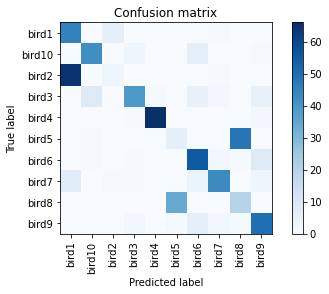

------------------------------------------------------------
----------------- Classification Report CNN1 ---------------
------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.38      0.87      0.53        52
         1.0       0.81      0.81      0.81        52
         2.0       0.30      0.04      0.08        69
         3.0       0.83      0.65      0.73        60
         4.0       0.99      0.96      0.97        69
         5.0       0.15      0.11      0.12        55
         6.0       0.72      0.81      0.76        68
         7.0       0.84      0.73      0.78        59
         8.0       0.29      0.37      0.32        54
         9.0       0.72      0.81      0.76        62

    accuracy                           0.61       600
   macro avg       0.60      0.61      0.59       600
weighted avg       0.61      0.61      0.59       600



In [ ]:
##---------------------------------------------
##------------ Classification Report ----------
##---------------------------------------------
# CNN report and analysis
import numpy as np
#yPred = np.argmax(pred_Y, axis=1)
#yTest = valid_label  #np.argmax(test_label, axis=1) no es necesario por que nuestro test_label ya tiene la forma
labelNames =valid_dataset.class_names
#cnn_f1 = metrics.f1_score(yTest, yPred, average= "weighted")
#cnn_accuracy = metrics.accuracy_score(yTest, yPred)
cnn_cm = metrics.confusion_matrix(yTest, yPred)
print("-------------------------------------------")
print("--------- Plotting confusion matrix--------")
print("-------------------------------------------")
#print("CNN2 Trainning Time: {:0.2f} minute".format(cnn2_time/60.0))
#print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cnn_cm, labelNames)
plt.show()
print("------------------------------------------------------------")
print("----------------- Classification Report CNN1 ---------------")
print("------------------------------------------------------------")
print(metrics.classification_report(yTest, yPred))  

# Model#2

---



In [ ]:
import keras
#from keras.models import Sequential,Input,Model
from tensorflow.keras.layers import Input
#from tensorflow.keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.layers.advanced_activations import LeakyReLU
from keras.layers import ELU, PReLU, LeakyReLU
from keras.layers import LeakyReLU
import tensorflow as tf 
INIT_LR = 1e-3
#epochs = 10
batch_size = 64
 

 


In [ ]:
cnn2 = Sequential()
cnn2.add(Conv2D(32, kernel_size=(3, 3),strides=1,activation='linear',input_shape=(256,256,3)))
cnn2.add(LeakyReLU(alpha=0.1))
cnn2.add(Dropout(0.5))
cnn2.add(Conv2D(64, kernel_size=(3, 3),strides=1, activation='linear'))
cnn2.add(Dropout(0.5))
cnn2.add(LeakyReLU(alpha=0.1))
cnn2.add(Conv2D(128, kernel_size=(3, 3),strides=2,activation='linear'))
cnn2.add(LeakyReLU(alpha=0.1))
cnn2.add(MaxPooling2D((2, 2),strides=2))
cnn2.add(Dropout(0.5))


cnn2.add(Flatten())
cnn2.add(Dense(128, activation='selu'))
cnn2.add(Dense(64, activation='selu'))
cnn2.add(Dense(32, activation='selu'))
cnn2.add(Dropout(0.5)) 
cnn2.add(Dense(NO_CLASSES, activation='softmax',kernel_initializer='lecun_normal'))
 
cnn2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 254, 254, 32)      0         
                                                                 
 dropout_32 (Dropout)        (None, 254, 254, 32)      0         
                                                                 
 conv2d_43 (Conv2D)          (None, 252, 252, 64)      18496     
                                                                 
 dropout_33 (Dropout)        (None, 252, 252, 64)      0         
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 252, 252, 64)      0         
                                                                 
 conv2d_44 (Conv2D)          (None, 125, 125, 128)    

In [ ]:
cnn2.compile(
      loss=keras.losses.sparse_categorical_crossentropy, 
      optimizer=tf.keras.optimizers.legacy.Adagrad(learning_rate=INIT_LR, decay=INIT_LR / 100)
      ,metrics=['accuracy']
)

#cnn2.compile(optimizers.rmsprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])


In [ ]:
import time
start1 = time.time()
# Train model for 10 epochs, capture the history
history_cnn2 = cnn2.fit(train_esc, epochs=80, validation_data=valid_esc)
end1 = time.time()
cnn2_time = end1-start1
print("CNN #2 Time: {:0.2f} minute".format(cnn2_time/60.0))

Epoch 1/80
75/75 [==============================] - 6s 63ms/step - loss: 2.6614 - accuracy: 0.1388 - val_loss: 2.2455 - val_accuracy: 0.1767
Epoch 2/80
75/75 [==============================] - 5s 61ms/step - loss: 2.2214 - accuracy: 0.1950 - val_loss: 2.2033 - val_accuracy: 0.2467
Epoch 3/80
75/75 [==============================] - 5s 61ms/step - loss: 2.1325 - accuracy: 0.2204 - val_loss: 2.1801 - val_accuracy: 0.2633
Epoch 4/80
75/75 [==============================] - 5s 61ms/step - loss: 2.0454 - accuracy: 0.2692 - val_loss: 2.1421 - val_accuracy: 0.2833
Epoch 5/80
75/75 [==============================] - 5s 61ms/step - loss: 1.9822 - accuracy: 0.2725 - val_loss: 2.0998 - val_accuracy: 0.3667
Epoch 6/80
75/75 [==============================] - 5s 61ms/step - loss: 1.9206 - accuracy: 0.3113 - val_loss: 2.0627 - val_accuracy: 0.3317
Epoch 7/80
75/75 [==============================] - 5s 61ms/step - loss: 1.8647 - accuracy: 0.3300 - val_loss: 2.0291 - val_accuracy: 0.3333
Epoch 8/80
75

##  ***Generating evaluation metrics CNN2 ***
 
 Asignamos los resultados de model.fit a un objeto history. Esto nos permitirá ver los resultados de las pruebas

In [ ]:
# es necesario que el  predict y el ytest esten en el mismo for, con eso garantizamos que ambos trabajen con el mismo conjunto de datos
from sklearn.metrics import confusion_matrix
from sklearn import metrics
yPred = np.array([])
yTest =  np.array([])
for x, y in valid_esc:
  yPred = np.concatenate([yPred, np.argmax(cnn2.predict(x), axis = -1)])
  yTest = np.concatenate([yTest, y.numpy()])  # no es necesario el argmax  aqui np.argmax(y.numpy(), axis=-1)

1/1 [==============================] - 0s 101ms/step


In [ ]:
cnn_f1 = metrics.f1_score(yTest, yPred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(yTest, yPred)
cnn_precision = metrics.precision_score(yTest, yPred,average="micro" )
cnn_recall = metrics.recall_score (yTest, yPred,average="micro" )
print("--------------------------------------------")
print("-----------------CNN2 Summary---------------")
print("--------------------------------------------")
print("CNN Time: {:0.2f} minute".format(cnn2_time/60.0))
print("F1 score: {}".format(cnn_f1))
print("Accuracy score: {}".format(cnn_accuracy))
print("Precision score: {}".format(cnn_precision))
print("Recall score: {}".format(cnn_recall))


--------------------------------------------
-----------------CNN2 Summary---------------
--------------------------------------------
CNN Time: 6.44 minute
F1 score: 0.4270821688675332
Accuracy score: 0.41
Precision score: 0.41
Recall score: 0.41


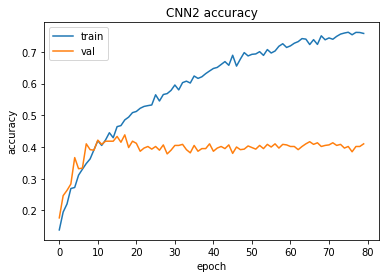

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history_cnn2.history['accuracy'])
plt.plot(history_cnn2.history['val_accuracy'])
plt.title('CNN2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

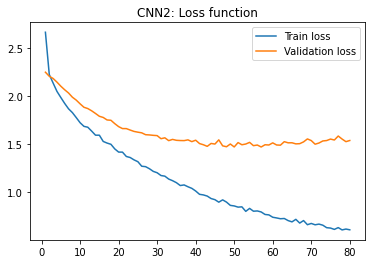

In [ ]:
hist_cnn2 = history_cnn2.history
loss = hist_cnn2['loss']
val_loss = hist_cnn2['val_loss']
x = np.arange(80) + 1  #nro de epchs +1

plt.title("CNN2: Loss function")
plt.plot(x, loss, label="Train loss")
plt.plot(x, val_loss, label="Validation loss")
plt.legend()
plt.show()

In [ ]:
# Otra forma de obtener label de train y test pero   no funcina con el from_directry por que  con cada ejecuciion se actualizan los sets
#train_label = np.concatenate([y for x, y in train_esc], axis=0)
#valid_label = np.concatenate([y for x, y in valid_esc], axis=0)


In [ ]:
yPred

In [ ]:
yTest

In [ ]:
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

-------------------------------------------
---------Plotting confusion matrix---------
-------------------------------------------


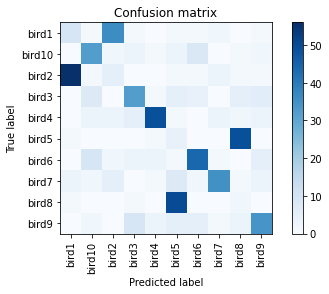

------------------------------------------------------------
----------------- Classification Report CNN2 ---------------
------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.13      0.17      0.15        52
         1.0       0.56      0.62      0.59        52
         2.0       0.09      0.07      0.08        69
         3.0       0.59      0.53      0.56        60
         4.0       0.83      0.71      0.77        69
         5.0       0.05      0.07      0.06        55
         6.0       0.68      0.65      0.66        68
         7.0       0.78      0.59      0.67        59
         8.0       0.03      0.04      0.03        54
         9.0       0.62      0.55      0.58        62

    accuracy                           0.41       600
   macro avg       0.44      0.40      0.42       600
weighted avg       0.45      0.41      0.43       600



In [ ]:
# CNN report and analysis
import numpy as np
#yPred = np.argmax(pred_Y, axis=1)
#yTest = valid_label  #np.argmax(test_label, axis=1) no es necesario por que nuestro test_label ya tiene la forma
labelNames =valid_dataset.class_names
cnn_f1 = metrics.f1_score(yTest, yPred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(yTest, yPred)
cnn_cm = metrics.confusion_matrix(yTest, yPred)
print("-------------------------------------------")
print("---------Plotting confusion matrix---------")
print("-------------------------------------------")

plt.figure()
plot_confusion_matrix(cnn_cm, labelNames)
plt.show()
print("------------------------------------------------------------")
print("----------------- Classification Report CNN2 ---------------")
print("------------------------------------------------------------")
print(metrics.classification_report(yTest, yPred ))

#Model #3

---



In [ ]:
from keras.callbacks import ModelCheckpoint
#from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GRU
from keras.layers import Activation, Dropout, Flatten, Dense, TimeDistributed


cnn3 = Sequential()

cnn3.add(Conv2D(32,(3,3),padding='same',
                input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,NO_CHANNELS),
                activation='tanh'))
cnn2.add(Dropout(0.6))   
cnn3.add(Conv2D(32,(3,3),strides=2,padding='same',activation='tanh'))
cnn3.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn3.add(Conv2D(64,(3,3),strides=2,padding='same',activation='tanh'))
cnn2.add(Dropout(0.6))

cnn3.add(Conv2D(64,(3,3),strides=2,padding='same',activation='tanh'))
cnn3.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn3.add(Conv2D(128,(3,3),strides=2,padding='same',activation='tanh'))
cnn2.add(Dropout(0.6))
cnn3.add(Conv2D(128,(3,3),strides=2,padding='same',activation='tanh'))
cnn3.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn3.add(Conv2D(256,(3,3),strides=2,padding='same',activation='tanh'))
cnn2.add(Dropout(0.6))
cnn3.add(Conv2D(256,(3,3),strides=2,padding='same',activation='tanh'))
#cnn3.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))


cnn3.add(Flatten())
cnn3.add(Dense(32))
cnn2.add(Dropout(0.5))
cnn3.add(Dense(32))
cnn2.add(Dropout(0.5))
cnn3.add(Dense(32))
cnn2.add(Dropout(0.5))
cnn3.add(Dense(32))
cnn2.add(Dropout(0.5))
cnn3.add(Dense(10))
cnn3.add(Activation('softmax'))

cnn3.summary()
 

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_212 (Conv2D)         (None, 256, 256, 32)      896       
                                                                 
 conv2d_213 (Conv2D)         (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_94 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_214 (Conv2D)         (None, 32, 32, 64)        18496     
                                                                 
 conv2d_215 (Conv2D)         (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_95 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                

In [ ]:
#cnn3.compile(
#      loss=keras.losses.sparse_categorical_crossentropy, 
#      optimizer=tf.optimizers.Adam()
#      ,metrics=['accuracy']
#)
cnn3.compile(
      loss=keras.losses.sparse_categorical_crossentropy, 
      optimizer=tf.keras.optimizers.legacy.Adagrad(learning_rate=INIT_LR, decay=INIT_LR / 100)
      ,metrics=['accuracy']
)

In [ ]:
start1 = time.time()
# Train model for 10 epochs, capture the history
history_cnn3 = cnn3.fit(train_esc, epochs=250, validation_data=valid_esc)
end1 = time.time()
cnn3_time = end1-start1
print("CNN #3 Time: {:0.2f} minute".format(cnn3_time/60.0))

Epoch 1/250
75/75 [==============================] - 4s 39ms/step - loss: 2.3025 - accuracy: 0.0938 - val_loss: 2.3026 - val_accuracy: 0.1100
Epoch 2/250
75/75 [==============================] - 3s 36ms/step - loss: 2.3022 - accuracy: 0.1054 - val_loss: 2.3028 - val_accuracy: 0.1017
Epoch 3/250
75/75 [==============================] - 3s 36ms/step - loss: 2.3020 - accuracy: 0.1071 - val_loss: 2.3030 - val_accuracy: 0.1000
Epoch 4/250
75/75 [==============================] - 3s 37ms/step - loss: 2.3018 - accuracy: 0.1133 - val_loss: 2.3031 - val_accuracy: 0.1000
Epoch 5/250
75/75 [==============================] - 3s 36ms/step - loss: 2.3016 - accuracy: 0.1129 - val_loss: 2.3031 - val_accuracy: 0.1017
Epoch 6/250
75/75 [==============================] - 3s 36ms/step - loss: 2.3014 - accuracy: 0.1163 - val_loss: 2.3032 - val_accuracy: 0.1033
Epoch 7/250
75/75 [==============================] - 3s 35ms/step - loss: 2.3013 - accuracy: 0.1208 - val_loss: 2.3032 - val_accuracy: 0.1050
Epoch 

##  ***Generating evaluation metrics CNN3 ***
 
 Asignamos los resultados de model.fit a un objeto history. Esto nos permitirá ver los resultados de las pruebas

In [ ]:
##---------------------------------------------
##------------ Classification Report ----------
##---------------------------------------------
# es necesario que el  predict y el ytest esten en el mismo for, con eso garantizamos que ambos trabajen con el mismo conjunto de datos
from sklearn.metrics import confusion_matrix
from sklearn import metrics
yPred = np.array([])
yTest =  np.array([])
for x, y in valid_esc:
  yPred = np.concatenate([yPred, np.argmax(cnn3.predict(x), axis = -1)])
  yTest = np.concatenate([yTest, y.numpy()])  # no es necesario el argmax  aqui np.argmax(y.numpy(), axis=-1)

cnn_f1 = metrics.f1_score(yTest, yPred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(yTest, yPred)
cnn_precision = metrics.precision_score(yTest, yPred,average="micro" )
cnn_recall = metrics.recall_score (yTest, yPred,average="micro" )
print("--------------------------------------------")
print("-----------------CNN3 Summary---------------")
print("--------------------------------------------")
print("CNN Time: {:0.2f} minute".format(cnn3_time/60.0))
print("F1 score: {}".format(cnn_f1))
print("Accuracy score: {}".format(cnn_accuracy))
print("Precision score: {}".format(cnn_precision))
print("Recall score: {}".format(cnn_recall))

1/1 [==============================] - 0s 156ms/step
--------------------------------------------
-----------------CNN3 Summary---------------
--------------------------------------------
CNN Time: 12.50 minute
F1 score: 0.5871271802933857
Accuracy score: 0.5866666666666667
Precision score: 0.5866666666666667
Recall score: 0.5866666666666667


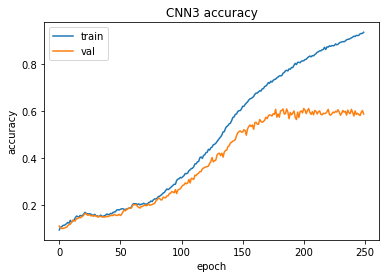

In [ ]:
##---------------------------------------------
##-------------- Accuracy evolution -----------
##---------------------------------------------
from matplotlib import pyplot as plt
plt.plot(history_cnn3.history['accuracy'])
plt.plot(history_cnn3.history['val_accuracy'])
plt.title('CNN3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

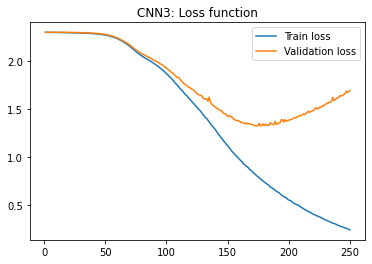

In [ ]:
##---------------------------------------------
##-------------- Loss evolution -----------
##---------------------------------------------
hist_cnn3 = history_cnn3.history
loss = hist_cnn3['loss']
val_loss = hist_cnn3['val_loss']
x = np.arange(250) + 1

plt.title("CNN3: Loss function")
plt.plot(x, loss, label="Train loss")
plt.plot(x, val_loss, label="Validation loss")
plt.legend()
plt.show()

-------------------------------------------
--------Plotting confusion matrix'---------
-------------------------------------------


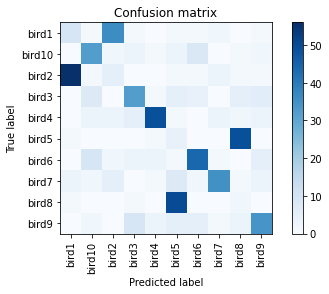

------------------------------------------------------------
----------------- Classification Report CNN3 ---------------
------------------------------------------------------------
              precision    recall  f1-score   support

       bird1       0.61      0.69      0.65        52
      bird10       0.63      0.65      0.64        52
       bird2       0.51      0.45      0.48        69
       bird3       0.71      0.62      0.66        60
       bird4       0.72      0.59      0.65        69
       bird5       0.67      0.60      0.63        55
       bird6       0.51      0.59      0.54        68
       bird7       0.57      0.54      0.56        59
       bird8       0.50      0.69      0.58        54
       bird9       0.53      0.50      0.51        62

    accuracy                           0.59       600
   macro avg       0.60      0.59      0.59       600
weighted avg       0.59      0.59      0.59       600



In [ ]:
##---------------------------------------------
##------------ Classification Report ----------
##---------------------------------------------
# CNN report and analysis
import numpy as np
#yPred = np.argmax(pred_Y, axis=1)
#yTest = valid_label  #np.argmax(test_label, axis=1) no es necesario por que nuestro test_label ya tiene la forma
labelNames =valid_dataset.class_names
#cnn_f1 = metrics.f1_score(yTest, yPred, average= "weighted")
#cnn_accuracy = metrics.accuracy_score(yTest, yPred)
#cnn_cm = metrics.confusion_matrix(yTest, yPred)
print("-------------------------------------------")
print("--------Plotting confusion matrix'---------")
print("-------------------------------------------")


plt.figure()
plot_confusion_matrix(cnn_cm, labelNames)
plt.show()
print("------------------------------------------------------------")
print("----------------- Classification Report CNN3 ---------------")
print("------------------------------------------------------------")
print(metrics.classification_report(yTest, yPred , target_names=labelNames))  

# Model#4

---



In [ ]:
# Create CNN #4 model
# Accelerate Learning of Deep Neural Networks With Batch Normalization
# Use Before or After the Activation Function
# Some reported experiments suggest better performance when adding the batch normalization layer after the activation function of the previous laye
# https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/
#
#from extra_keras_datasets import kmnist
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

cnn4 = Sequential()
    
cnn4.add(Conv2D(16,(3,3),padding='same',input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,NO_CHANNELS),activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn4.add(BatchNormalization())
cnn4.add(Conv2D(32,(3,3),padding='same',activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn4.add(BatchNormalization())
cnn4.add(Conv2D(32,(3,3),padding='same',activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn4.add(BatchNormalization())
cnn4.add(Conv2D(64,(3,3),padding='same',activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn4.add(BatchNormalization())
cnn4.add(Conv2D(64,(3,3),padding='same',activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn4.add(BatchNormalization())
cnn4.add(Conv2D(128,(3,3),padding='same',activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn4.add(BatchNormalization())
cnn4.add(Conv2D(128,(3,3),padding='same',activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn4.add(BatchNormalization())
cnn4.add(Conv2D(128,(3,3),padding='same',activation='relu'))
cnn4.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
cnn4.add(BatchNormalization())

cnn4.add(Flatten())
cnn4.add(Dense(32,activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.5))
cnn4.add(Dense(32,activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.5))
cnn4.add(Dense(32,activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.5))
cnn4.add(Dense(32,activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.5))
cnn4.add(Dense(10))
cnn4.add(Activation('softmax'))

cnn4.summary()

In [ ]:
# Compile model
cnn4.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

In [ ]:
# Train model for 10 epochs, capture the history
start1 = time.time()
# Train model for 10 epochs, capture the history
history_cnn4 = cnn4.fit(train_esc, epochs=100, validation_data=valid_esc)
end1 = time.time()
cnn4_time = end1-start1
print("CNN #4 Time: {:0.2f} minute".format(cnn4_time/60.0))

In [ ]:
# Train model for 10 epochs, capture the history
start1 = time.time()
# Train model for 10 epochs, capture the history
history_cnn4 = cnn4.fit(train_esc, epochs=100, validation_data=valid_esc)
end1 = time.time()
cnn4_time = end1-start1
print("CNN #4 Time: {:0.2f} minute".format(cnn4_time/60.0))

Epoch 1/100
75/75 [==============================] - 13s 49ms/step - loss: 3.1321 - accuracy: 0.1083 - val_loss: 2.3233 - val_accuracy: 0.1133
Epoch 2/100
75/75 [==============================] - 4s 44ms/step - loss: 2.8460 - accuracy: 0.1271 - val_loss: 2.3174 - val_accuracy: 0.0900
Epoch 3/100
75/75 [==============================] - 3s 42ms/step - loss: 2.5357 - accuracy: 0.1517 - val_loss: 2.3000 - val_accuracy: 0.0967
Epoch 4/100
75/75 [==============================] - 3s 42ms/step - loss: 2.3745 - accuracy: 0.1667 - val_loss: 2.5026 - val_accuracy: 0.1217
Epoch 5/100
75/75 [==============================] - 4s 43ms/step - loss: 2.1545 - accuracy: 0.2054 - val_loss: 1.8184 - val_accuracy: 0.2867
Epoch 6/100
75/75 [==============================] - 4s 44ms/step - loss: 2.0007 - accuracy: 0.2317 - val_loss: 2.0845 - val_accuracy: 0.1800
Epoch 7/100
75/75 [==============================] - 3s 42ms/step - loss: 1.8298 - accuracy: 0.2962 - val_loss: 1.9347 - val_accuracy: 0.2500
Epoch

##  ***Generating evaluation metrics CNN4 ***


In [ ]:
##---------------------------------------------
##------------ Classification Report ----------
##---------------------------------------------
# es necesario que el  predict y el ytest esten en el mismo for, con eso garantizamos que ambos trabajen con el mismo conjunto de datos
from sklearn.metrics import confusion_matrix
from sklearn import metrics
yPred = np.array([])
yTest =  np.array([])
for x, y in valid_esc:
  yPred = np.concatenate([yPred, np.argmax(cnn4.predict(x), axis = -1)])
  yTest = np.concatenate([yTest, y.numpy()])  # no es necesario el argmax  aqui np.argmax(y.numpy(), axis=-1)

cnn_f1 = metrics.f1_score(yTest, yPred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(yTest, yPred)
cnn_precision = metrics.precision_score(yTest, yPred,average="micro" )
cnn_recall = metrics.recall_score (yTest, yPred,average="micro" )
print("--------------------------------------------")
print("-----------------CNN4 Summary---------------")
print("--------------------------------------------")
print("CNN Time: {:0.2f} minute".format(cnn4_time/60.0))
print("F1 score: {}".format(cnn_f1))
print("Accuracy score: {}".format(cnn_accuracy))
print("Precision score: {}".format(cnn_precision))
print("Recall score: {}".format(cnn_recall))

1/1 [==============================] - 0s 345ms/step
--------------------------------------------
-----------------CNN4 Summary---------------
--------------------------------------------
CNN Time: 6.10 minute
F1 score: 1.0
Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0


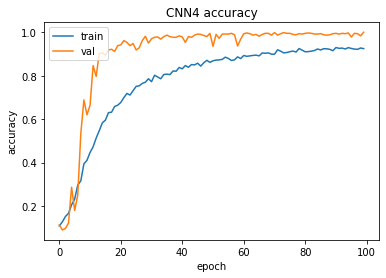

In [ ]:
##---------------------------------------------
##-------------- Accuracy evolution -----------
##---------------------------------------------
from matplotlib import pyplot as plt
plt.plot(history_cnn4.history['accuracy'])
plt.plot(history_cnn4.history['val_accuracy'])
plt.title('CNN4 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

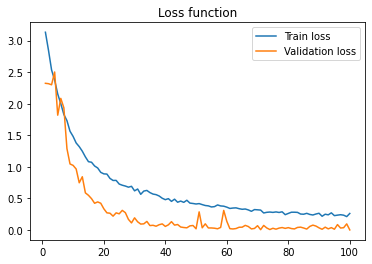

In [ ]:
##---------------------------------------------
##-------------- Loss evolution -----------
##---------------------------------------------
hist_cnn4 = history_cnn4.history
loss = hist_cnn4['loss']
val_loss = hist_cnn4['val_loss']
x = np.arange(100) + 1

plt.title("Loss function")
plt.plot(x, loss, label="Train loss")
plt.plot(x, val_loss, label="Validation loss")
plt.legend()
plt.show()


  
  

1/1 [==============================] - 0s 31ms/step
-------------------------------------------
-----------------CNN4 Summary---------------
-------------------------------------------
CNN2 Trainning Time: 8.42 minute
Plotting confusion matrix


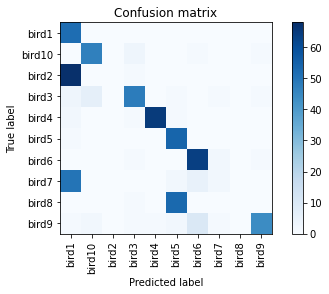

------------------------------------------------------------
----------------- Classification Report CNN4 ---------------
------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.29      1.00      0.45        52
         1.0       0.85      0.90      0.88        52
         2.0       0.00      0.00      0.00        69
         3.0       0.86      0.80      0.83        60
         4.0       0.98      0.94      0.96        69
         5.0       0.48      0.98      0.64        55
         6.0       0.80      0.94      0.86        68
         7.0       0.33      0.03      0.06        59
         8.0       0.00      0.00      0.00        54
         9.0       0.94      0.71      0.81        62

    accuracy                           0.63       600
   macro avg       0.55      0.63      0.55       600
weighted avg       0.56      0.63      0.56       600



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
##---------------------------------------------
##------------ Classification Report ----------
##---------------------------------------------
# CNN report and analysis
# es necesario que el  predict y el ytest esten en el mismo for, con eso garantizamos que ambos trabajen con el mismo conjunto de datos
from sklearn.metrics import confusion_matrix
from sklearn import metrics
yPred = np.array([])
yTest =  np.array([])
for x, y in valid_esc:
  yPred = np.concatenate([yPred, np.argmax(cnn4.predict(x), axis = -1)])
  yTest = np.concatenate([yTest, y.numpy()])  # no es necesario el argmax  aqui np.argmax(y.numpy(), axis=-1)
  
import numpy as np
#yPred = np.argmax(pred_Y, axis=1)
#yTest = valid_label  #np.argmax(test_label, axis=1) no es necesario por que nuestro test_label ya tiene la forma
labelNames =valid_dataset.class_names
cnn_f1 = metrics.f1_score(yTest, yPred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(yTest, yPred)
cnn_cm = metrics.confusion_matrix(yTest, yPred)
print("-------------------------------------------")
print("-----------------CNN4 Summary---------------")
print("-------------------------------------------")
print("CNN2 Trainning Time: {:0.2f} minute".format(cnn4_time/60.0))
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cnn_cm, labelNames)
plt.show()
print("------------------------------------------------------------")
print("----------------- Classification Report CNN4 ---------------")
print("------------------------------------------------------------")
print(metrics.classification_report(yTest, yPred))  

#Model#5  :  CNN4-DENSENET
Tranfer Learning - DenseNet


---



In [ ]:
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,BatchNormalization
#from keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.optimizers import Adam , SGD, RMSprop

In [ ]:
base_denseNet = tf.keras.applications.densenet.DenseNet201(weights='imagenet', input_shape =(IMAGE_HEIGHT, IMAGE_WIDTH, NO_CHANNELS),
                                                     include_top=False)

for layer in base_denseNet.layers:
    layer.trainable = False

In [ ]:
model_DenseNet=Sequential()
model_DenseNet.add(base_denseNet)
model_DenseNet.add(GlobalAveragePooling2D())
model_DenseNet.add(Flatten())
model_DenseNet.add(Dense(300, activation="relu"))
model_DenseNet.add(BatchNormalization())
#model_DenseNet.add(Dropout(0.5))

model_DenseNet.add(Dense(300, activation="relu"))
model_DenseNet.add(BatchNormalization())
model_DenseNet.add(Dropout(0.5))

model_DenseNet.add(Dense(300, activation="relu"))
model_DenseNet.add(BatchNormalization())
#model_DenseNet.add(Dropout(0.5))

model_DenseNet.add(Dense(100,activation='relu'))
model_DenseNet.add(BatchNormalization())
model_DenseNet.add(Dropout(0.5))

model_DenseNet.add(Dense(NO_CLASSES,activation="softmax"))
model_DenseNet.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 global_average_pooling2d_8   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_36 (Flatten)        (None, 1920)              0         
                                                                 
 dense_136 (Dense)           (None, 300)               576300    
                                                                 
 batch_normalization_19 (Bat  (None, 300)              1200      
 chNormalization)                                                
                                                                 
 dense_137 (Dense)           (None, 300)             

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
#initial_learning_rate = 1e-2,final_learning_rate = 1e-6,decay_steps = 10000
learning_rate = optimizers.schedules.PolynomialDecay(1e-5,10000,1e-6,power=0.4)
model_DenseNet.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=1e-5, patience=10, mode='auto',
                                              restore_best_weights=False, verbose=1),
                ModelCheckpoint(filepath='mask_detection_model.h5', monitor='accuracy', save_best_only=True, 
                                save_weights_only=False,
                                mode='auto', save_freq='epoch', verbose=1)]

In [ ]:

start1 = time.time()
# Train model for 10 epochs, capture the history
history_denseNet = model_DenseNet.fit(train_esc, validation_data = valid_esc, epochs = 250, steps_per_epoch=len(train_esc),
                    callbacks = [callbacks], verbose = 1)
end1 = time.time()
denseNet_time = end1-start1
print("DenseNet Time: {:0.2f} minute".format(denseNet_time/60.0))

Epoch 1/250
74/75 [============================>.] - ETA: 0s - loss: 3.6084 - accuracy: 0.1018
Epoch 1: accuracy improved from -inf to 0.10208, saving model to mask_detection_model.h5
75/75 [==============================] - 25s 130ms/step - loss: 3.6098 - accuracy: 0.1021 - val_loss: 2.3531 - val_accuracy: 0.1117
Epoch 2/250
75/75 [==============================] - ETA: 0s - loss: 3.5100 - accuracy: 0.1142
Epoch 2: accuracy improved from 0.10208 to 0.11417, saving model to mask_detection_model.h5
75/75 [==============================] - 7s 84ms/step - loss: 3.5100 - accuracy: 0.1142 - val_loss: 2.3969 - val_accuracy: 0.1133
Epoch 3/250
75/75 [==============================] - ETA: 0s - loss: 3.3966 - accuracy: 0.1163
Epoch 3: accuracy improved from 0.11417 to 0.11625, saving model to mask_detection_model.h5
75/75 [==============================] - 6s 84ms/step - loss: 3.3966 - accuracy: 0.1163 - val_loss: 2.4157 - val_accuracy: 0.1317
Epoch 4/250
74/75 [============================>.]

In [ ]:
##---------------------------------------------
##------------ Clasification Repor ------------
##---------------------------------------------
# es necesario que el  predict y el ytest esten en el mismo for, con eso garantizamos que ambos trabajen con el mismo conjunto de datos
from sklearn.metrics import confusion_matrix
from sklearn import metrics
yPred = np.array([])
yTest =  np.array([])
for x, y in valid_esc:
  yPred = np.concatenate([yPred, np.argmax(model_DenseNet.predict(x), axis = -1)])
  yTest = np.concatenate([yTest, y.numpy()])  # no es necesario el argmax  aqui np.argmax(y.numpy(), axis=-1)

cnn_f1 = metrics.f1_score(yTest, yPred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(yTest, yPred)
cnn_precision = metrics.precision_score(yTest, yPred,average="micro" )
cnn_recall = metrics.recall_score (yTest, yPred,average="micro" )
print("--------------------------------------------")
print("-----------------CNN5 Summary---------------")
print("--------------------------------------------")
print("CNN Time: {:0.2f} minute".format(denseNet_time/60.0))
print("F1 score: {}".format(cnn_f1))
print("Accuracy score: {}".format(cnn_accuracy))
print("Precision score: {}".format(cnn_precision))
print("Recall score: {}".format(cnn_recall))

1/1 [==============================] - 3s 3s/step
--------------------------------------------
-----------------CNN5 Summary---------------
--------------------------------------------
CNN Time: 10.62 minute
F1 score: 0.5420588013528738
Accuracy score: 0.5433333333333333
Precision score: 0.5433333333333333
Recall score: 0.5433333333333333


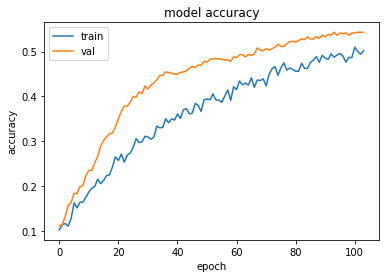

In [ ]:
##---------------------------------------------
##-------------- Accuracy evolution -----------
##---------------------------------------------
from matplotlib import pyplot as plt
plt.plot(history_denseNet.history['accuracy'])
plt.plot(history_denseNet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

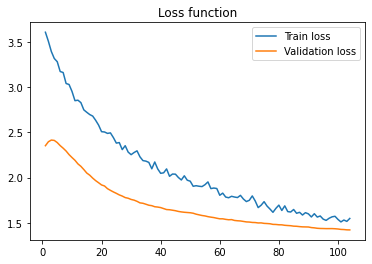

In [ ]:
##---------------------------------------------
##-------------- Loss evolution -----------
##---------------------------------------------
hist_denseNet = history_denseNet.history
loss = hist_denseNet['loss']
val_loss = hist_denseNet['val_loss']
x = np.arange(104) + 1

plt.title("Loss function")
plt.plot(x, loss, label="Train loss")
plt.plot(x, val_loss, label="Validation loss")
plt.legend()
plt.show()


-------------------------------------------
-----------------DensNet Summary---------------
-------------------------------------------
CNN2 Trainning Time: 10.62 minute
Plotting confusion matrix


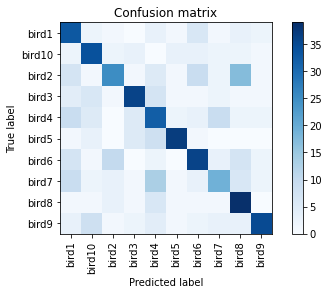

------------------------------------------------------------
----------------- Classification Report CNN2 ---------------
------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.43      0.63      0.52        52
         1.0       0.54      0.65      0.59        52
         2.0       0.54      0.36      0.43        69
         3.0       0.67      0.60      0.63        60
         4.0       0.40      0.46      0.43        69
         5.0       0.77      0.67      0.72        55
         6.0       0.55      0.53      0.54        68
         7.0       0.45      0.32      0.38        59
         8.0       0.49      0.72      0.58        54
         9.0       0.76      0.56      0.65        62

    accuracy                           0.54       600
   macro avg       0.56      0.55      0.55       600
weighted avg       0.56      0.54      0.54       600



In [ ]:
##---------------------------------------------
##------------ Classification Report ----------
##---------------------------------------------
# CNN report and analysis
import numpy as np
#yPred = np.argmax(pred_Y, axis=1)
#yTest = valid_label  #np.argmax(test_label, axis=1) no es necesario por que nuestro test_label ya tiene la forma
labelNames =valid_dataset.class_names
cnn_f1 = metrics.f1_score(yTest, yPred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(yTest, yPred)
cnn_cm = metrics.confusion_matrix(yTest, yPred)
print("-------------------------------------------")
print("-----------------DensNet Summary---------------")
print("-------------------------------------------")
print("CNN Trainning Time: {:0.2f} minute".format(denseNet_time/60.0))
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cnn_cm, labelNames)
plt.show()
print("------------------------------------------------------------")
print("----------------- Classification Report CNN ---------------")
print("------------------------------------------------------------")
print(metrics.classification_report(yTest, yPred))  



---


## MODEL #6

---



In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

cnn6 = Sequential()
    
cnn6.add(Conv2D(16,(3,3),padding='same',input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,NO_CHANNELS),activation='relu'))
cnn6.add(BatchNormalization())
cnn6.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn6.add(BatchNormalization())
cnn6.add(Conv2D(32,(3,3),padding='same',activation='relu'))
cnn6.add(BatchNormalization())
cnn6.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn6.add(BatchNormalization())
cnn6.add(Conv2D(32,(3,3),padding='same',activation='relu'))
cnn6.add(BatchNormalization())
cnn6.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn6.add(BatchNormalization())
cnn6.add(Conv2D(64,(3,3),padding='same',activation='relu'))
cnn6.add(BatchNormalization())
cnn6.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn6.add(BatchNormalization())
cnn6.add(Conv2D(64,(3,3),padding='same',activation='relu'))
cnn6.add(BatchNormalization())
cnn6.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn6.add(BatchNormalization())
cnn6.add(Conv2D(128,(3,3),padding='same',activation='relu'))
cnn6.add(BatchNormalization())
cnn6.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn6.add(BatchNormalization())
cnn6.add(Conv2D(128,(3,3),padding='same',activation='relu'))
cnn6.add(BatchNormalization())
cnn6.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn6.add(BatchNormalization())
cnn6.add(Conv2D(128,(3,3),padding='same',activation='relu'))
cnn6.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
cnn6.add(BatchNormalization())

cnn6.add(Flatten())
cnn6.add(Dense(32,activation='relu'))
cnn6.add(BatchNormalization())
cnn6.add(Dropout(0.5))
cnn6.add(Dense(32,activation='relu'))
cnn6.add(BatchNormalization())
cnn6.add(Dropout(0.5))
cnn6.add(Dense(32,activation='relu'))
cnn6.add(BatchNormalization())
cnn6.add(Dropout(0.5))
cnn6.add(Dense(32,activation='relu'))
cnn6.add(BatchNormalization())
cnn6.add(Dropout(0.5))
cnn6.add(Dense(10))
cnn6.add(Activation('softmax'))

cnn6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 batch_normalization_32 (Bat  (None, 256, 256, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 batch_normalization_33 (Bat  (None, 128, 128, 16)     64        
 chNormalization)                                                
                                                                 
 conv2d_14 (Conv2D)          (None, 128, 128, 32)      4640      
                                                      

In [ ]:
cnn6.compile(
      loss='sparse_categorical_crossentropy', 
      optimizer=tf.optimizers.Adam()
      ,metrics=['accuracy']
)

In [ ]:
start1 = time.time()
# Train model for 10 epochs, capture the history
history_cnn6 = cnn6.fit(train_esc, epochs=100, validation_data=valid_esc)
end1 = time.time()
cnn6_time = end1-start1
print("CNN #3 Time: {:0.2f} minute".format(cnn3_time/60.0))

Epoch 1/100
75/75 [==============================] - 15s 46ms/step - loss: 3.1036 - accuracy: 0.1171 - val_loss: 2.3238 - val_accuracy: 0.0917
Epoch 2/100
75/75 [==============================] - 3s 40ms/step - loss: 2.9437 - accuracy: 0.1042 - val_loss: 2.3288 - val_accuracy: 0.1150
Epoch 3/100
75/75 [==============================] - 3s 40ms/step - loss: 2.7975 - accuracy: 0.1017 - val_loss: 2.3444 - val_accuracy: 0.0867
Epoch 4/100
75/75 [==============================] - 3s 41ms/step - loss: 2.6412 - accuracy: 0.1125 - val_loss: 2.3815 - val_accuracy: 0.0850
Epoch 5/100
75/75 [==============================] - 3s 40ms/step - loss: 2.5822 - accuracy: 0.1125 - val_loss: 2.3777 - val_accuracy: 0.1217
Epoch 6/100
75/75 [==============================] - 3s 40ms/step - loss: 2.4620 - accuracy: 0.1238 - val_loss: 2.3384 - val_accuracy: 0.1183
Epoch 7/100
75/75 [==============================] - 3s 40ms/step - loss: 2.4360 - accuracy: 0.1196 - val_loss: 2.2819 - val_accuracy: 0.1350
Epoch

NameError: ignored

In [ ]:
##---------------------------------------------
##------------ Classification Report ----------
##---------------------------------------------
# es necesario que el  predict y el ytest esten en el mismo for, con eso garantizamos que ambos trabajen con el mismo conjunto de datos
from sklearn.metrics import confusion_matrix
from sklearn import metrics
yPred = np.array([])
yTest =  np.array([])
for x, y in valid_esc:
  yPred = np.concatenate([yPred, np.argmax(cnn6.predict(x), axis = -1)])
  yTest = np.concatenate([yTest, y.numpy()])  # no es necesario el argmax  aqui np.argmax(y.numpy(), axis=-1)

cnn_f1 = metrics.f1_score(yTest, yPred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(yTest, yPred)
cnn_precision = metrics.precision_score(yTest, yPred,average="micro" )
cnn_recall = metrics.recall_score (yTest, yPred,average="micro" )
print("--------------------------------------------")
print("-----------------CNN3 Summary---------------")
print("--------------------------------------------")
print("CNN Time: {:0.2f} minute".format(cnn6_time/60.0))
print("F1 score: {}".format(cnn_f1))
print("Accuracy score: {}".format(cnn_accuracy))
print("Precision score: {}".format(cnn_precision))
print("Recall score: {}".format(cnn_recall))

1/1 [==============================] - 0s 344ms/step
--------------------------------------------
-----------------CNN3 Summary---------------
--------------------------------------------
CNN Time: 13.81 minute
F1 score: 0.6660606455236321
Accuracy score: 0.7183333333333334
Precision score: 0.7183333333333334
Recall score: 0.7183333333333334


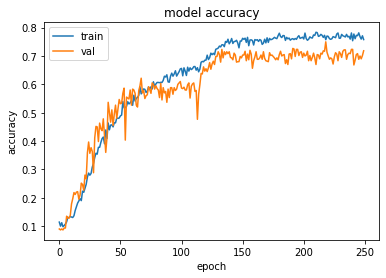

In [ ]:
##---------------------------------------------
##-------------- Accuracy evolution -----------
##---------------------------------------------
from matplotlib import pyplot as plt
plt.plot(history_cnn6.history['accuracy'])
plt.plot(history_cnn6.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
cnn_f1 = metrics.f1_score(yTest, yPred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(yTest, yPred)
cnn_precision = metrics.precision_score(yTest, yPred,average="micro" )
cnn_recall = metrics.recall_score (yTest, yPred,average="micro" )
print("--------------------------------------------")
print("-----------------CNN6 Summary---------------")
print("--------------------------------------------")
print("CNN Time: {:0.2f} minute".format(cnn6_time/60.0))
print("F1 score: {}".format(cnn_f1))
print("Accuracy score: {}".format(cnn_accuracy))
print("Precision score: {}".format(cnn_precision))
print("Recall score: {}".format(cnn_recall))

--------------------------------------------
-----------------CNN6 Summary---------------
--------------------------------------------
CNN Time: 13.81 minute
F1 score: 0.6660606455236321
Accuracy score: 0.7183333333333334
Precision score: 0.7183333333333334
Recall score: 0.7183333333333334


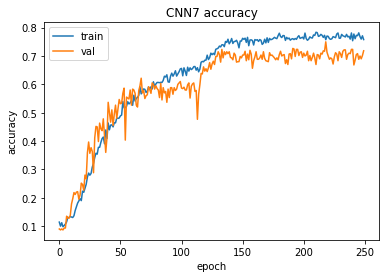

In [ ]:
##---------------------------------------------
##-------------- Accuracy evolution -----------
##---------------------------------------------
from matplotlib import pyplot as plt
plt.plot(history_cnn6.history['accuracy'])
plt.plot(history_cnn6.history['val_accuracy'])
plt.title('CNN7 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

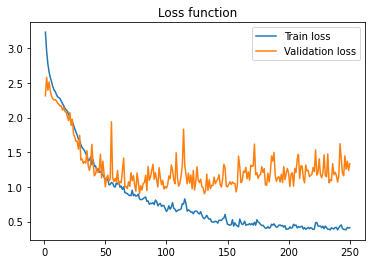

In [ ]:
##---------------------------------------------
##-------------- Loss evolution -----------
##---------------------------------------------
hist_cnn6 = history_cnn6.history
loss = hist_cnn6['loss']
val_loss = hist_cnn6['val_loss']
x = np.arange(250) + 1

plt.title("Loss function")
plt.plot(x, loss, label="Train loss")
plt.plot(x, val_loss, label="Validation loss")
plt.legend()
plt.show()

-------------------------------------------
-----------------CNN6 Summary---------------
-------------------------------------------
CNN6 Trainning Time: 13.81 minute
Plotting confusion matrix


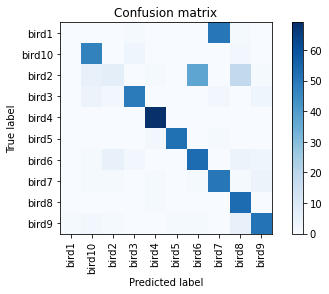

------------------------------------------------------------
----------------- Classification Report CNN6 ---------------
------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        52
         1.0       0.78      0.90      0.84        52
         2.0       0.44      0.10      0.16        69
         3.0       0.89      0.82      0.85        60
         4.0       0.93      1.00      0.97        69
         5.0       0.98      0.95      0.96        55
         6.0       0.58      0.78      0.66        68
         7.0       0.49      0.85      0.62        59
         8.0       0.63      0.98      0.77        54
         9.0       0.82      0.82      0.82        62

    accuracy                           0.72       600
   macro avg       0.65      0.72      0.67       600
weighted avg       0.66      0.72      0.67       600



In [ ]:
import numpy as np
#yPred = np.argmax(pred_Y, axis=1)
#yTest = valid_label  #np.argmax(test_label, axis=1) no es necesario por que nuestro test_label ya tiene la forma
labelNames =valid_dataset.class_names
cnn_f1 = metrics.f1_score(yTest, yPred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(yTest, yPred)
cnn_cm = metrics.confusion_matrix(yTest, yPred)
print("-------------------------------------------")
print("-----------------CNN6 Summary---------------")
print("-------------------------------------------")
print("CNN6 Trainning Time: {:0.2f} minute".format(cnn6_time/60.0))
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cnn_cm, labelNames)
plt.show()
print("------------------------------------------------------------")
print("----------------- Classification Report CNN6 ---------------")
print("------------------------------------------------------------")
print(metrics.classification_report(yTest, yPred)) 



---


MODEL # 7
---



In [ ]:
# Create CNN #4 model
# Accelerate Learning of Deep Neural Networks With Batch Normalization
# Use Before or After the Activation Function
# Some reported experiments suggest better performance when adding the batch normalization layer after the activation function of the previous laye
# https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/
#
#from extra_keras_datasets import kmnist
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

cnn7 = Sequential()
    
cnn7.add(Conv2D(16,(3,3),padding='same',input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,NO_CHANNELS),activation='relu'))
cnn7.add(BatchNormalization())
cnn7.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn7.add(BatchNormalization())
cnn7.add(Conv2D(32,(3,3),padding='same',activation='relu'))
cnn7.add(BatchNormalization())
cnn7.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn7.add(BatchNormalization())
cnn7.add(Conv2D(32,(3,3),padding='same',activation='relu'))
cnn7.add(BatchNormalization())
cnn7.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn7.add(BatchNormalization())
cnn7.add(Conv2D(64,(3,3),padding='same',activation='relu'))
cnn7.add(BatchNormalization())
cnn7.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn7.add(BatchNormalization())
cnn7.add(Conv2D(64,(3,3),padding='same',activation='relu'))
cnn7.add(BatchNormalization())
cnn7.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn7.add(BatchNormalization())
cnn7.add(Conv2D(128,(3,3),padding='same',activation='relu'))
cnn7.add(BatchNormalization())
cnn7.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn7.add(BatchNormalization())
cnn7.add(Conv2D(128,(3,3),padding='same',activation='relu'))
cnn7.add(BatchNormalization())
cnn7.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn7.add(BatchNormalization())
cnn7.add(Conv2D(128,(3,3),padding='same',activation='relu'))
cnn7.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
cnn7.add(BatchNormalization())

cnn7.add(Flatten())
cnn7.add(Dense(32,activation='relu'))
cnn7.add(BatchNormalization())
cnn7.add(Dropout(0.5))
cnn7.add(Dense(32,activation='relu'))
cnn7.add(BatchNormalization())
cnn7.add(Dropout(0.5))
cnn7.add(Dense(32,activation='relu'))
cnn7.add(BatchNormalization())
cnn7.add(Dropout(0.5))
cnn7.add(Dense(32,activation='relu'))
cnn7.add(BatchNormalization())
cnn7.add(Dropout(0.5))
cnn7.add(Dense(10))
cnn7.add(Activation('softmax'))

In [ ]:
# Compile model
cnn7.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

In [ ]:
# Train model for 10 epochs, capture the history
start1 = time.time()
# Train model for 10 epochs, capture the history
history_cnn7 = cnn7.fit(train_esc, epochs=300, validation_data=valid_esc)
end1 = time.time()
cnn7_time = end1-start1
print("CNN #7 Time: {:0.2f} minute".format(cnn7_time/60.0))

Epoch 1/300
75/75 [==============================] - 11s 98ms/step - loss: 3.2630 - accuracy: 0.1075 - val_loss: 2.3032 - val_accuracy: 0.1150
Epoch 2/300
75/75 [==============================] - 7s 87ms/step - loss: 2.9765 - accuracy: 0.1054 - val_loss: 2.3829 - val_accuracy: 0.0883
Epoch 3/300
75/75 [==============================] - 8s 97ms/step - loss: 2.8086 - accuracy: 0.1021 - val_loss: 3.1227 - val_accuracy: 0.1250
Epoch 4/300
75/75 [==============================] - 7s 89ms/step - loss: 2.6675 - accuracy: 0.1017 - val_loss: 2.5734 - val_accuracy: 0.1000
Epoch 5/300
75/75 [==============================] - 8s 97ms/step - loss: 2.5857 - accuracy: 0.0946 - val_loss: 2.4010 - val_accuracy: 0.1150
Epoch 6/300
75/75 [==============================] - 7s 90ms/step - loss: 2.5153 - accuracy: 0.1050 - val_loss: 2.3445 - val_accuracy: 0.0967
Epoch 7/300
75/75 [==============================] - 7s 91ms/step - loss: 2.4570 - accuracy: 0.1054 - val_loss: 2.3483 - val_accuracy: 0.1083
Epoch

In [ ]:
##---------------------------------------------
##------------ Classification Report ----------
##---------------------------------------------
# es necesario que el  predict y el ytest esten en el mismo for, con eso garantizamos que ambos trabajen con el mismo conjunto de datos
from sklearn.metrics import confusion_matrix
from sklearn import metrics
yPred = np.array([])
yTest =  np.array([])
for x, y in valid_esc:
  yPred = np.concatenate([yPred, np.argmax(cnn7.predict(x), axis = -1)])
  yTest = np.concatenate([yTest, y.numpy()])  # no es necesario el argmax  aqui np.argmax(y.numpy(), axis=-1)

1/1 [==============================] - 0s 27ms/step


In [ ]:
cnn_f1 = metrics.f1_score(yTest, yPred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(yTest, yPred)
cnn_precision = metrics.precision_score(yTest, yPred,average="micro" )
cnn_recall = metrics.recall_score (yTest, yPred,average="micro" )
print("--------------------------------------------")
print("-----------------CNN4 Summary---------------")
print("--------------------------------------------")
print("CNN Time: {:0.2f} minute".format(cnn7_time/60.0))
print("F1 score: {}".format(cnn_f1))
print("Accuracy score: {}".format(cnn_accuracy))
print("Precision score: {}".format(cnn_precision))
print("Recall score: {}".format(cnn_recall))

--------------------------------------------
-----------------CNN4 Summary---------------
--------------------------------------------
CNN Time: 37.82 minute
F1 score: 0.7302101388284409
Accuracy score: 0.765
Precision score: 0.765
Recall score: 0.765


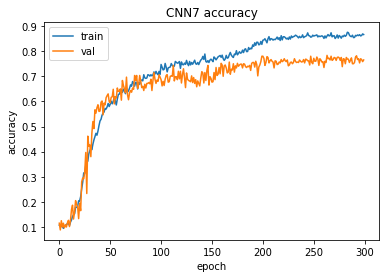

In [ ]:
##---------------------------------------------
##-------------- Accuracy evolution -----------
##---------------------------------------------
from matplotlib import pyplot as plt
plt.plot(history_cnn7.history['accuracy'])
plt.plot(history_cnn7.history['val_accuracy'])
plt.title('CNN7 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

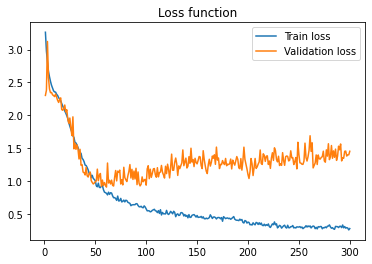

In [ ]:
##---------------------------------------------
##-------------- Loss evolution -----------
##---------------------------------------------
hist_cnn7 = history_cnn7.history
loss = hist_cnn7['loss']
val_loss = hist_cnn7['val_loss']
x = np.arange(300) + 1

plt.title("Loss function")
plt.plot(x, loss, label="Train loss")
plt.plot(x, val_loss, label="Validation loss")
plt.legend()
plt.show()

-------------------------------------------
-----------------CNN7 Summary---------------
-------------------------------------------
CNN7 Trainning Time: 25.40 minute
Plotting confusion matrix


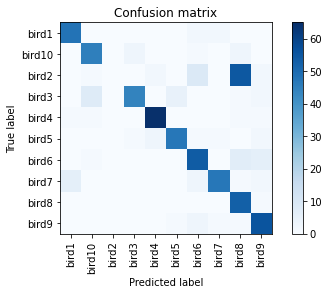

------------------------------------------------------------
----------------- Classification Report CNN2 ---------------
------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.92      0.90        52
         1.0       0.80      0.87      0.83        52
         2.0       0.00      0.00      0.00        69
         3.0       0.92      0.73      0.81        60
         4.0       0.93      0.94      0.94        69
         5.0       0.89      0.85      0.87        55
         6.0       0.74      0.79      0.77        68
         7.0       0.92      0.80      0.85        59
         8.0       0.43      0.98      0.60        54
         9.0       0.78      0.90      0.84        62

    accuracy                           0.77       600
   macro avg       0.73      0.78      0.74       600
weighted avg       0.72      0.77      0.73       600



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import numpy as np
#yPred = np.argmax(pred_Y, axis=1)
#yTest = valid_label  #np.argmax(test_label, axis=1) no es necesario por que nuestro test_label ya tiene la forma
labelNames =valid_dataset.class_names
cnn_f1 = metrics.f1_score(yTest, yPred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(yTest, yPred)
cnn_cm = metrics.confusion_matrix(yTest, yPred)
print("-------------------------------------------")
print("-----------------CNN7 Summary---------------")
print("-------------------------------------------")
print("CNN7 Trainning Time: {:0.2f} minute".format(cnn4_time/60.0))
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cnn_cm, labelNames)
plt.show()
print("------------------------------------------------------------")
print("----------------- Classification Report CNN2 ---------------")
print("------------------------------------------------------------")
print(metrics.classification_report(yTest, yPred))  



---




```
# This is formatted as code
```

## **MODEL  #8 : CNN2-BATCH

---



In [ ]:
# Create CNN #4 model
# Accelerate Learning of Deep Neural Networks With Batch Normalization
# Use Before or After the Activation Function
# Some reported experiments suggest better performance when adding the batch normalization layer after the activation function of the previous laye
# https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/
#
#from extra_keras_datasets import kmnist
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

cnn8 = Sequential()
    
cnn8.add(Conv2D(16,(3,3),padding='same',input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,NO_CHANNELS),activation='relu'))
cnn8.add(BatchNormalization())
cnn8.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn8.add(BatchNormalization())
cnn8.add(Conv2D(32,(3,3),padding='same',activation='relu'))
cnn8.add(BatchNormalization())
cnn8.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn8.add(BatchNormalization())
cnn8.add(Conv2D(32,(3,3),padding='same',activation='relu'))
cnn8.add(BatchNormalization())
cnn8.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn8.add(BatchNormalization())
cnn8.add(Conv2D(64,(3,3),padding='same',activation='relu'))
cnn8.add(BatchNormalization())
cnn8.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn8.add(BatchNormalization())
cnn8.add(Conv2D(64,(3,3),padding='same',activation='relu'))
cnn8.add(BatchNormalization())
cnn8.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn8.add(BatchNormalization())
cnn8.add(Conv2D(128,(3,3),padding='same',activation='relu'))
cnn8.add(BatchNormalization())
cnn8.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn8.add(BatchNormalization())
cnn8.add(Conv2D(128,(3,3),padding='same',activation='relu'))
cnn8.add(BatchNormalization())
cnn8.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn8.add(BatchNormalization())
cnn8.add(Conv2D(128,(3,3),padding='same',activation='relu'))
cnn8.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
cnn8.add(BatchNormalization())

cnn8.add(Flatten())
cnn8.add(Dense(32,activation='relu'))
cnn8.add(BatchNormalization())
cnn8.add(Dropout(0.5))
cnn8.add(Dense(32,activation='relu'))
cnn8.add(BatchNormalization())
cnn8.add(Dropout(0.5))
cnn8.add(Dense(32,activation='relu'))
cnn8.add(BatchNormalization())
cnn8.add(Dropout(0.5))
cnn8.add(Dense(32,activation='relu'))
cnn8.add(BatchNormalization())
cnn8.add(Dropout(0.5))
cnn8.add(Dense(10))
cnn8.add(Activation('softmax'))


cnn8.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                        

In [ ]:
# Compile model
cnn8.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

In [ ]:
# Train model for 10 epochs, capture the history
start1 = time.time()
# Train model for 10 epochs, capture the history
history_cnn8 = cnn8.fit(train_esc, epochs=300, validation_data=valid_esc)
end1 = time.time()
cnn8_time = end1-start1
print("CNN #7 Time: {:0.2f} minute".format(cnn8_time/60.0))

Epoch 1/300
75/75 [==============================] - 11s 44ms/step - loss: 3.1097 - accuracy: 0.1117 - val_loss: 2.3652 - val_accuracy: 0.0867
Epoch 2/300
75/75 [==============================] - 3s 39ms/step - loss: 2.8802 - accuracy: 0.1121 - val_loss: 2.4694 - val_accuracy: 0.1033
Epoch 3/300
75/75 [==============================] - 3s 39ms/step - loss: 2.7952 - accuracy: 0.0988 - val_loss: 2.4752 - val_accuracy: 0.0733
Epoch 4/300
75/75 [==============================] - 3s 39ms/step - loss: 2.6663 - accuracy: 0.1008 - val_loss: 2.3891 - val_accuracy: 0.0917
Epoch 5/300
75/75 [==============================] - 3s 39ms/step - loss: 2.5749 - accuracy: 0.1079 - val_loss: 2.4147 - val_accuracy: 0.0800
Epoch 6/300
75/75 [==============================] - 3s 39ms/step - loss: 2.5208 - accuracy: 0.0971 - val_loss: 2.3118 - val_accuracy: 0.1283
Epoch 7/300
75/75 [==============================] - 3s 39ms/step - loss: 2.4619 - accuracy: 0.1096 - val_loss: 2.2922 - val_accuracy: 0.1217
Epoch

In [ ]:
##---------------------------------------------
##------------ Classification Report ----------
##---------------------------------------------
# es necesario que el  predict y el ytest esten en el mismo for, con eso garantizamos que ambos trabajen con el mismo conjunto de datos
from sklearn.metrics import confusion_matrix
from sklearn import metrics
yPred = np.array([])
yTest =  np.array([])
for x, y in valid_esc:
  yPred = np.concatenate([yPred, np.argmax(cnn8.predict(x), axis = -1)])
  yTest = np.concatenate([yTest, y.numpy()])  # no es necesario el argmax  aqui np.argmax(y.numpy(), axis=-1)

1/1 [==============================] - 0s 332ms/step


In [ ]:
cnn_f1 = metrics.f1_score(yTest, yPred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(yTest, yPred)
cnn_precision = metrics.precision_score(yTest, yPred,average="micro" )
cnn_recall = metrics.recall_score (yTest, yPred,average="micro" )
print("--------------------------------------------")
print("-----------------CNN8 Summary---------------")
print("--------------------------------------------")
print("CNN Time: {:0.2f} minute".format(cnn8_time/60.0))
print("F1 score: {}".format(cnn_f1))
print("Accuracy score: {}".format(cnn_accuracy))
print("Precision score: {}".format(cnn_precision))
print("Recall score: {}".format(cnn_recall))

--------------------------------------------
-----------------CNN8 Summary---------------
--------------------------------------------
CNN Time: 15.89 minute
F1 score: 0.759990055713271
Accuracy score: 0.785
Precision score: 0.785
Recall score: 0.785


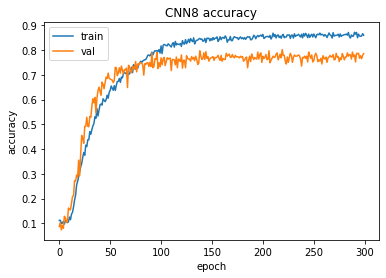

In [ ]:
##---------------------------------------------
##-------------- Accuracy evolution -----------
##---------------------------------------------
from matplotlib import pyplot as plt
plt.plot(history_cnn8.history['accuracy'])
plt.plot(history_cnn8.history['val_accuracy'])
plt.title('CNN8 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

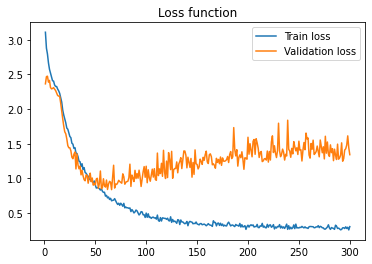

In [ ]:
##---------------------------------------------
##-------------- Loss evolution -----------
##---------------------------------------------
hist_cnn8= history_cnn8.history
loss = hist_cnn8['loss']
val_loss = hist_cnn8['val_loss']
x = np.arange(300) + 1

plt.title("Loss function")
plt.plot(x, loss, label="Train loss")
plt.plot(x, val_loss, label="Validation loss")
plt.legend()
plt.show()

-------------------------------------------
-----------------CNN8 Summary---------------
-------------------------------------------
CNN7 Trainning Time: 15.89 minute
Plotting confusion matrix


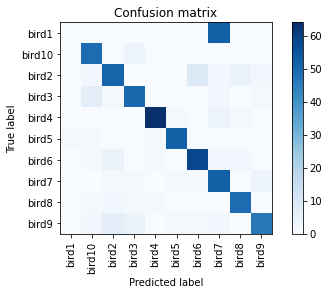

------------------------------------------------------------
----------------- Classification Report CNN8 ---------------
------------------------------------------------------------
              precision    recall  f1-score   support

       bird1       0.00      0.00      0.00        52
      bird10       0.79      0.94      0.86        52
       bird2       0.78      0.74      0.76        69
       bird3       0.85      0.83      0.84        60
       bird4       0.96      0.93      0.94        69
       bird5       0.95      0.95      0.95        55
       bird6       0.85      0.85      0.85        68
       bird7       0.45      0.88      0.60        59
       bird8       0.88      0.91      0.89        54
       bird9       0.88      0.74      0.81        62

    accuracy                           0.79       600
   macro avg       0.74      0.78      0.75       600
weighted avg       0.75      0.79      0.76       600



In [ ]:
import numpy as np
#yPred = np.argmax(pred_Y, axis=1)
#yTest = valid_label  #np.argmax(test_label, axis=1) no es necesario por que nuestro test_label ya tiene la forma
labelNames =valid_dataset.class_names
cnn_f1 = metrics.f1_score(yTest, yPred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(yTest, yPred)
cnn_cm = metrics.confusion_matrix(yTest, yPred)
print("-------------------------------------------")
print("-----------------CNN8 Summary---------------")
print("-------------------------------------------")
print("CNN7 Trainning Time: {:0.2f} minute".format(cnn8_time/60.0))
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cnn_cm, labelNames)
plt.show()
print("------------------------------------------------------------")
print("----------------- Classification Report CNN8 ---------------")
print("------------------------------------------------------------")
print(metrics.classification_report(yTest, yPred ,target_names=labelNames))  



---


## MODELO 4.1


---



In [ ]:
# Create CNN #4 model
# Accelerate Learning of Deep Neural Networks With Batch Normalization
# Use Before or After the Activation Function
# Some reported experiments suggest better performance when adding the batch normalization layer after the activation function of the previous laye
# https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/
#
#from extra_keras_datasets import kmnist
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

cnn41 = Sequential()
    
cnn41.add(Conv2D(16,(3,3),padding='same',input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,NO_CHANNELS),activation='linear'))
cnn41.add(LeakyReLU(alpha=0.05))
cnn41.add(BatchNormalization())
cnn41.add(MaxPooling2D(pool_size=(3,3),strides=2,padding = 'same'))

#cnn41.add(BatchNormalization())
cnn41.add(Conv2D(32,(3,3),padding='same',activation='linear'))
cnn41.add(LeakyReLU(alpha=0.05))
cnn41.add(BatchNormalization())
cnn41.add(MaxPooling2D(pool_size=(3,3),strides=2,padding = 'same'))

#cnn41.add(BatchNormalization())
#cnn41.add(Conv2D(32,(3,3),padding='same',activation='relu'))
#cnn41.add(BatchNormalization())
#cnn41.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

#cnn41.add(BatchNormalization())
cnn41.add(Conv2D(64,(3,3),padding='same',activation='linear'))
cnn41.add(LeakyReLU(alpha=0.05))
cnn41.add(BatchNormalization())
cnn41.add(MaxPooling2D(pool_size=(3,3),strides=2,padding = 'same'))

#cnn41.add(BatchNormalization())
#cnn41.add(Conv2D(64,(3,3),padding='same',activation='relu'))
#cnn41.add(BatchNormalization())
#cnn41.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

#cnn41.add(BatchNormalization())
cnn41.add(Conv2D(128,(3,3),padding='same',activation='linear'))
cnn41.add(LeakyReLU(alpha=0.05))
cnn41.add(BatchNormalization())
cnn41.add(MaxPooling2D(pool_size=(3,3),strides=2,padding = 'same'))

#cnn41.add(BatchNormalization())
#cnn41.add(Conv2D(128,(3,3),padding='same',activation='relu'))
#cnn41.add(BatchNormalization())
#cnn41.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

#cnn41.add(BatchNormalization())
cnn41.add(Conv2D(128,(3,3),padding='same',activation='linear'))
cnn41.add(LeakyReLU(alpha=0.05))
cnn41.add(MaxPooling2D(pool_size=(3,3),strides=2,padding = 'same'))
cnn41.add(BatchNormalization())

cnn41.add(Flatten())
cnn41.add(Dense(32,activation='relu'))
cnn41.add(BatchNormalization())
cnn41.add(Dropout(0.5))
cnn41.add(Dense(32,activation='relu'))
cnn41.add(BatchNormalization())
cnn41.add(Dropout(0.5))
cnn41.add(Dense(32,activation='relu'))
cnn41.add(BatchNormalization())
cnn41.add(Dropout(0.5))
cnn41.add(Dense(32,activation='relu'))
cnn41.add(BatchNormalization())
cnn41.add(Dropout(0.5))
cnn41.add(Dense(10))
cnn41.add(Activation('softmax'))

In [ ]:
# Compile model
learning_rate = optimizers.schedules.PolynomialDecay(1e-5,10000,1e-6,power=0.4)
cnn41.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
    metrics=['accuracy'],
)


#learning_rate = optimizers.schedules.PolynomialDecay(1e-5,10000,1e-6,power=0.4)
#model_DenseNet.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

In [ ]:
###41
# Train model for 10 epochs, capture the history
start1 = time.time()
# Train model for 10 epochs, capture the history
history_cnn41 = cnn41.fit(train_esc, epochs=200, validation_data=valid_esc)
end1 = time.time()
cnn41_time = end1-start1
print("CNN #41 Time: {:0.2f} minute".format(cnn41_time/60.0))


Epoch 1/200
75/75 [==============================] - 9s 39ms/step - loss: 3.3272 - accuracy: 0.0975 - val_loss: 2.3900 - val_accuracy: 0.0867
Epoch 2/200
75/75 [==============================] - 3s 38ms/step - loss: 3.3648 - accuracy: 0.0954 - val_loss: 2.5138 - val_accuracy: 0.0867
Epoch 3/200
75/75 [==============================] - 3s 37ms/step - loss: 3.3325 - accuracy: 0.0979 - val_loss: 2.5318 - val_accuracy: 0.0867
Epoch 4/200
75/75 [==============================] - 3s 36ms/step - loss: 3.3277 - accuracy: 0.1071 - val_loss: 2.4442 - val_accuracy: 0.0867
Epoch 5/200
75/75 [==============================] - 3s 37ms/step - loss: 3.2921 - accuracy: 0.1100 - val_loss: 2.4249 - val_accuracy: 0.0900
Epoch 6/200
75/75 [==============================] - 3s 36ms/step - loss: 3.2897 - accuracy: 0.1000 - val_loss: 2.3884 - val_accuracy: 0.1233
Epoch 7/200
75/75 [==============================] - 3s 38ms/step - loss: 3.2700 - accuracy: 0.1125 - val_loss: 2.3740 - val_accuracy: 0.1200
Epoch 

In [ ]:
##---------------------------------------------
##------------ Classification Report ----------
##---------------------------------------------
# es necesario que el  predict y el ytest esten en el mismo for, con eso garantizamos que ambos trabajen con el mismo conjunto de datos
from sklearn.metrics import confusion_matrix
from sklearn import metrics
yPred = np.array([])
yTest =  np.array([])
for x, y in valid_esc:
  yPred = np.concatenate([yPred, np.argmax(cnn41.predict(x), axis = -1)])
  yTest = np.concatenate([yTest, y.numpy()])  # no es necesario el argmax  aqui np.argmax(y.numpy(), axis=-1)

cnn_f1 = metrics.f1_score(yTest, yPred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(yTest, yPred)
cnn_precision = metrics.precision_score(yTest, yPred,average="micro" )
cnn_recall = metrics.recall_score (yTest, yPred,average="micro" )
print("--------------------------------------------")
print("-----------------CNN Summary---------------")
print("--------------------------------------------")
print("CNN Time: {:0.2f} minute".format(cnn41_time/60.0))
print("F1 score: {}".format(cnn_f1))
print("Accuracy score: {}".format(cnn_accuracy))
print("Precision score: {}".format(cnn_precision))
print("Recall score: {}".format(cnn_recall))

NameError: ignored

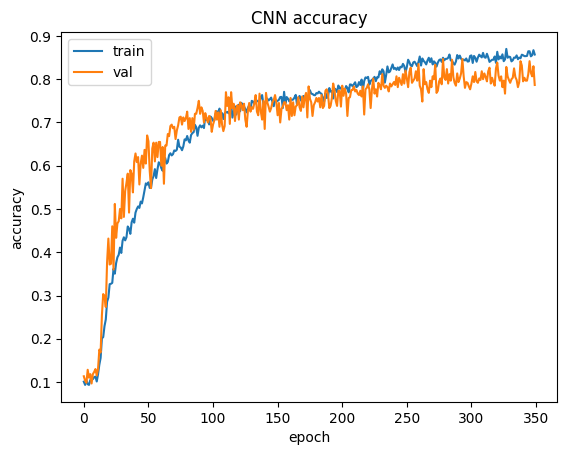

In [ ]:
##---------------------------------------------
##-------------- Accuracy evolution -----------
##---------------------------------------------
from matplotlib import pyplot as plt
plt.plot(history_cnn41.history['accuracy'])
plt.plot(history_cnn41.history['val_accuracy'])
plt.title('CNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

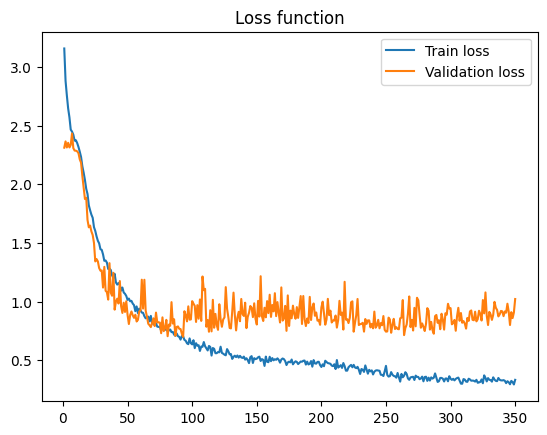

In [ ]:
##---------------------------------------------
##-------------- Loss evolution -----------
##---------------------------------------------
hist_cnn41 = history_cnn41.history
loss = hist_cnn41['loss']
val_loss = hist_cnn41['val_loss']
x = np.arange(350) + 1

plt.title("Loss function")
plt.plot(x, loss, label="Train loss")
plt.plot(x, val_loss, label="Validation loss")
plt.legend()
plt.show()

In [ ]:
##---------------------------------------------
##------------ Classification Report ----------
##---------------------------------------------
# CNN report and analysis
# es necesario que el  predict y el ytest esten en el mismo for, con eso garantizamos que ambos trabajen con el mismo conjunto de datos
from sklearn.metrics import confusion_matrix
from sklearn import metrics
yPred = np.array([])
yTest =  np.array([])
for x, y in valid_esc:
  yPred = np.concatenate([yPred, np.argmax(cnn41.predict(x), axis = -1)])
  yTest = np.concatenate([yTest, y.numpy()])  # no es necesario el argmax  aqui np.argmax(y.numpy(), axis=-1)
  
import numpy as np
#yPred = np.argmax(pred_Y, axis=1)
#yTest = valid_label  #np.argmax(test_label, axis=1) no es necesario por que nuestro test_label ya tiene la forma
labelNames =valid_dataset.class_names
cnn_f1 = metrics.f1_score(yTest, yPred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(yTest, yPred)
cnn_cm = metrics.confusion_matrix(yTest, yPred)
print("-------------------------------------------")
print("-----------------CNN Summary---------------")
print("-------------------------------------------")
print("CNN2 Trainning Time: {:0.2f} minute".format(cnn41_time/60.0))
print('Plotting confusion matrix')

1/1 [==============================] - 0s 32ms/step
-------------------------------------------
-----------------CNN Summary---------------
-------------------------------------------
CNN2 Trainning Time: 21.47 minute
Plotting confusion matrix


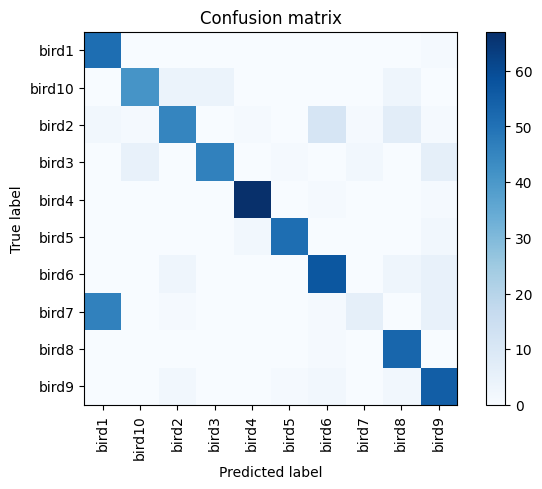

------------------------------------------------------------
----------------- Classification Report CNN ---------------
------------------------------------------------------------
              precision    recall  f1-score   support

       bird1       0.52      0.98      0.68        52
      bird10       0.87      0.79      0.83        52
       bird2       0.82      0.65      0.73        69
       bird3       0.92      0.77      0.84        60
       bird4       0.96      0.97      0.96        69
       bird5       0.96      0.93      0.94        55
       bird6       0.78      0.84      0.81        68
       bird7       0.67      0.10      0.18        59
       bird8       0.78      0.98      0.87        54
       bird9       0.72      0.89      0.80        62

    accuracy                           0.79       600
   macro avg       0.80      0.79      0.76       600
weighted avg       0.80      0.79      0.76       600



In [ ]:
plt.figure()
plot_confusion_matrix(cnn_cm, labelNames)
plt.show()
print("------------------------------------------------------------")
print("----------------- Classification Report CNN ---------------")
print("------------------------------------------------------------")
print(metrics.classification_report(yTest, yPred, target_names = labelNames))




---



---


## MODEL : ASYM

In [ ]:
# Create LEALY REALUUUUUUUUUUUUUUUUUUUUUUUUU
# Accelerate Learning of Deep Neural Networks With Batch Normalization
# Use Before or After the Activation Function
# Some reported experiments suggest better performance when adding the batch normalization layer after the activation function of the previous laye
# https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/
#
#from extra_keras_datasets import kmnist
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

cnn41 = Sequential()
    
cnn41.add(Conv2D(16,(3,3),padding='same',input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,NO_CHANNELS),activation='linear'))
cnn41.add(LeakyReLU(alpha=0.05))
cnn41.add(BatchNormalization())
cnn41.add(MaxPooling2D(pool_size=(3,3),strides=2,padding = 'same'))

cnn41.add(BatchNormalization())
cnn41.add(Conv2D(32,(1,3),padding='same',activation='linear'))
cnn41.add(LeakyReLU(alpha=0.05))
cnn41.add(BatchNormalization())
cnn41.add(MaxPooling2D(pool_size=(1,3),strides=2,padding = 'same'))

#cnn41.add(BatchNormalization())
#cnn41.add(Conv2D(32,(3,3),padding='same',activation='relu'))
#cnn41.add(BatchNormalization())
#cnn41.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn41.add(BatchNormalization())
cnn41.add(Conv2D(64,(1,3),padding='same',activation='linear'))
cnn41.add(LeakyReLU(alpha=0.05))
cnn41.add(BatchNormalization())
cnn41.add(MaxPooling2D(pool_size=(1,3),strides=2,padding = 'same'))

#cnn41.add(BatchNormalization())
#cnn41.add(Conv2D(64,(3,3),padding='same',activation='relu'))
#cnn41.add(BatchNormalization())
#cnn41.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn41.add(BatchNormalization())
cnn41.add(Conv2D(128,(1,2),padding='same',activation='linear'))
cnn41.add(LeakyReLU(alpha=0.05))
cnn41.add(BatchNormalization())
cnn41.add(MaxPooling2D(pool_size=(1,2),strides=2,padding = 'same'))

#cnn41.add(BatchNormalization())
#cnn41.add(Conv2D(128,(3,3),padding='same',activation='relu'))
#cnn41.add(BatchNormalization())
#cnn41.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

cnn41.add(BatchNormalization())
cnn41.add(Conv2D(128,(1,2),padding='same',activation='linear'))
cnn41.add(LeakyReLU(alpha=0.05))
cnn41.add(MaxPooling2D(pool_size=(1,2),strides=2,padding = 'same'))
cnn41.add(BatchNormalization())

cnn41.add(Flatten())
cnn41.add(Dense(32,activation='linear'))
cnn41.add(LeakyReLU(alpha=0.05))
cnn41.add(BatchNormalization())
cnn41.add(Dropout(0.5))
cnn41.add(Dense(32,activation='linear'))
cnn41.add(LeakyReLU(alpha=0.05))
cnn41.add(BatchNormalization())
cnn41.add(Dropout(0.5))
cnn41.add(Dense(32,activation='linear'))
cnn41.add(LeakyReLU(alpha=0.05))
cnn41.add(BatchNormalization())
cnn41.add(Dropout(0.5))
cnn41.add(Dense(32,activation='linear'))
cnn41.add(LeakyReLU(alpha=0.05))
cnn41.add(BatchNormalization())
cnn41.add(Dropout(0.5))
cnn41.add(Dense(10))
cnn41.add(Activation('softmax'))

In [ ]:
# Compile model
from tensorflow.keras.optimizers import Adam , SGD, RMSprop
from tensorflow.keras import optimizers
learning_rate = optimizers.schedules.PolynomialDecay(1e-5,10000,1e-6,power=0.4)
cnn41.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
    metrics=['accuracy'],
)


#learning_rate = optimizers.schedules.PolynomialDecay(1e-5,10000,1e-6,power=0.4)
#model_DenseNet.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

In [ ]:
# Train model for 10 epochs, capture the history
start1 = time.time()
# Train model for 10 epochs, capture the history
history_cnn41 = cnn41.fit(train_esc, epochs=50, validation_data=valid_esc)
end1 = time.time()
cnn41_time = end1-start1
print("CNN #41 Time: {:0.2f} minute".format(cnn41_time/60.0))

Epoch 1/50
53/75 [====================>.........] - ETA: 0s - loss: 3.5064 - accuracy: 0.1032

KeyboardInterrupt: ignored



---



---


## CNN3-LEAKY RELU

---



In [ ]:
#cnn41.add(LeakyReLU(alpha=0.05))
# Create CNN #4 model
# Accelerate Learning of Deep Neural Networks With Batch Normalization
# Use Before or After the Activation Function
# Some reported experiments suggest better performance when adding the batch normalization layer after the activation function of the previous laye
# https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/
#
#from extra_keras_datasets import kmnist
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

cnn41 = Sequential()
    
cnn41.add(Conv2D(32,(7,7),strides=2,padding='same',input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,NO_CHANNELS),activation='relu'))
cnn41.add(LeakyReLU(alpha=0.05))
cnn41.add(BatchNormalization())
cnn41.add(MaxPooling2D(pool_size=(3,3),strides=2,padding = 'same'))

#cnn41.add(BatchNormalization())
cnn41.add(Conv2D(32,(7,7),strides=2,padding='same',activation='relu'))
cnn41.add(LeakyReLU(alpha=0.05))
cnn41.add(BatchNormalization())
cnn41.add(MaxPooling2D(pool_size=(3,3),strides=2,padding = 'same'))

#cnn41.add(BatchNormalization())
#cnn41.add(Conv2D(32,(3,3),padding='same',activation='relu'))
#cnn41.add(BatchNormalization())
#cnn41.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

#cnn41.add(BatchNormalization())
cnn41.add(Conv2D(64,(5,5),strides=2,padding='same',activation='relu'))
cnn41.add(LeakyReLU(alpha=0.05))
cnn41.add(BatchNormalization())
cnn41.add(MaxPooling2D(pool_size=(3,3),strides=2,padding = 'same'))

#cnn41.add(BatchNormalization())
#cnn41.add(Conv2D(64,(3,3),padding='same',activation='relu'))
#cnn41.add(BatchNormalization())
#cnn41.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

#cnn41.add(BatchNormalization())
cnn41.add(Conv2D(128,(5,5),strides=2,padding='same',activation='relu'))
cnn41.add(LeakyReLU(alpha=0.05))
cnn41.add(BatchNormalization())
cnn41.add(MaxPooling2D(pool_size=(3,3),strides=2,padding = 'same'))

#cnn41.add(BatchNormalization())
#cnn41.add(Conv2D(128,(3,3),padding='same',activation='relu'))
#cnn41.add(BatchNormalization())
#cnn41.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

#cnn41.add(BatchNormalization())
cnn41.add(Conv2D(128,(3,3),strides=2,padding='same',activation='relu'))
cnn41.add(LeakyReLU(alpha=0.05))
cnn41.add(MaxPooling2D(pool_size=(3,3),strides=2,padding = 'same'))
cnn41.add(BatchNormalization())

cnn41.add(Flatten())
cnn41.add(Dense(32,activation='relu'))
cnn41.add(LeakyReLU(alpha=0.06))
cnn41.add(BatchNormalization())
cnn41.add(Dropout(0.6))
cnn41.add(Dense(32,activation='relu'))
cnn41.add(LeakyReLU(alpha=0.05))
cnn41.add(BatchNormalization())
cnn41.add(Dropout(0.6))
cnn41.add(Dense(32,activation='relu'))
cnn41.add(LeakyReLU(alpha=0.05))
cnn41.add(BatchNormalization())
cnn41.add(Dropout(0.6))
cnn41.add(Dense(32,activation='relu'))
cnn41.add(LeakyReLU(alpha=0.05))
cnn41.add(BatchNormalization())
cnn41.add(Dropout(0.6))
cnn41.add(Dense(10))
cnn41.add(Activation('softmax'))

cnn41.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_85 (Conv2D)          (None, 128, 128, 32)      4736      
                                                                 
 leaky_re_lu_106 (LeakyReLU)  (None, 128, 128, 32)     0         
                                                                 
 batch_normalization_193 (Ba  (None, 128, 128, 32)     128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_86 (Conv2D)          (None, 32, 32, 32)        50208     
                                                                 
 leaky_re_lu_107 (LeakyReLU)  (None, 32, 32, 32)     

In [ ]:
# Compile model
from tensorflow.keras.optimizers import Adam , SGD, RMSprop
from tensorflow.keras import optimizers
learning_rate = optimizers.schedules.PolynomialDecay(1e-5,10000,1e-6,power=0.4)
INIT_LR = 1e-3
cnn41.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=INIT_LR),
    metrics=['accuracy'],
)
#import tensorflow as tf 


#cnn41.compile(
#     loss='sparse_categorical_crossentropy',
#      optimizer=tf.keras.optimizers.legacy.Adagrad(learning_rate=INIT_LR, decay=INIT_LR / 100)
#      ,metrics=['accuracy']
#)

#learning_rate = optimizers.schedules.PolynomialDecay(1e-5,10000,1e-6,power=0.4)
#cnn41.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

In [ ]:
# Train model for 10 epochs, capture the history
start1 = time.time()
# Train model for 10 epochs, capture the history
history_cnn41 = cnn41.fit(train_esc, epochs=350, validation_data=valid_esc)
end1 = time.time()
cnn41_time = end1-start1
print("CNN #41 Time: {:0.2f} minute".format(cnn41_time/60.0))

Epoch 1/350
75/75 [==============================] - 8s 35ms/step - loss: 3.3663 - accuracy: 0.1042 - val_loss: 2.3271 - val_accuracy: 0.0983
Epoch 2/350
75/75 [==============================] - 3s 35ms/step - loss: 3.1295 - accuracy: 0.0996 - val_loss: 2.3455 - val_accuracy: 0.0983
Epoch 3/350
75/75 [==============================] - 3s 35ms/step - loss: 2.9353 - accuracy: 0.0988 - val_loss: 2.3252 - val_accuracy: 0.1017
Epoch 4/350
75/75 [==============================] - 3s 35ms/step - loss: 2.7550 - accuracy: 0.1058 - val_loss: 2.3007 - val_accuracy: 0.1133
Epoch 5/350
75/75 [==============================] - 3s 35ms/step - loss: 2.6230 - accuracy: 0.1142 - val_loss: 2.3232 - val_accuracy: 0.0983
Epoch 6/350
75/75 [==============================] - 3s 37ms/step - loss: 2.5865 - accuracy: 0.0958 - val_loss: 2.3274 - val_accuracy: 0.0867
Epoch 7/350
75/75 [==============================] - 3s 35ms/step - loss: 2.4940 - accuracy: 0.0983 - val_loss: 2.3311 - val_accuracy: 0.1017
Epoch 

In [ ]:
##---------------------------------------------
##------------ Classification Report ----------
##---------------------------------------------
# es necesario que el  predict y el ytest esten en el mismo for, con eso garantizamos que ambos trabajen con el mismo conjunto de datos
from sklearn.metrics import confusion_matrix
from sklearn import metrics
yPred = np.array([])
yTest =  np.array([])
for x, y in valid_esc:
  yPred = np.concatenate([yPred, np.argmax(cnn41.predict(x), axis = -1)])
  yTest = np.concatenate([yTest, y.numpy()])  # no es necesario el argmax  aqui np.argmax(y.numpy(), axis=-1)

cnn_f1 = metrics.f1_score(yTest, yPred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(yTest, yPred)
cnn_precision = metrics.precision_score(yTest, yPred,average="micro" )
cnn_recall = metrics.recall_score (yTest, yPred,average="micro" )
print("--------------------------------------------")
print("-----------------CNN Summary---------------")
print("--------------------------------------------")
print("CNN Time: {:0.2f} minute".format(cnn41_time/60.0))
print("F1 score: {}".format(cnn_f1))
print("Accuracy score: {}".format(cnn_accuracy))
print("Precision score: {}".format(cnn_precision))
print("Recall score: {}".format(cnn_recall))

1/1 [==============================] - 0s 244ms/step
--------------------------------------------
-----------------CNN Summary---------------
--------------------------------------------
CNN Time: 17.12 minute
F1 score: 0.6945499406039656
Accuracy score: 0.7016666666666667
Precision score: 0.7016666666666667
Recall score: 0.7016666666666667


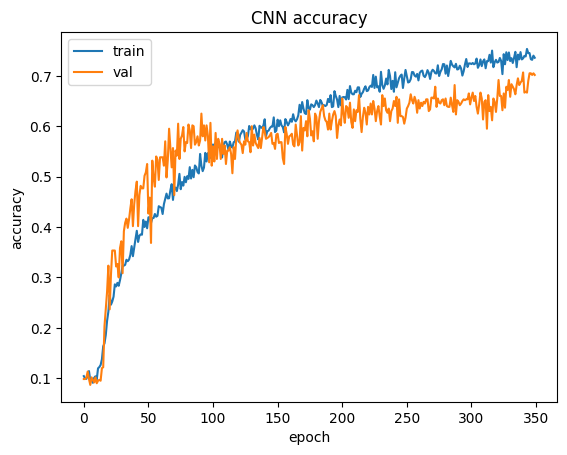

In [ ]:
##---------------------------------------------
##-------------- Accuracy evolution -----------
##---------------------------------------------
from matplotlib import pyplot as plt
plt.plot(history_cnn41.history['accuracy'])
plt.plot(history_cnn41.history['val_accuracy'])
plt.title('CNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


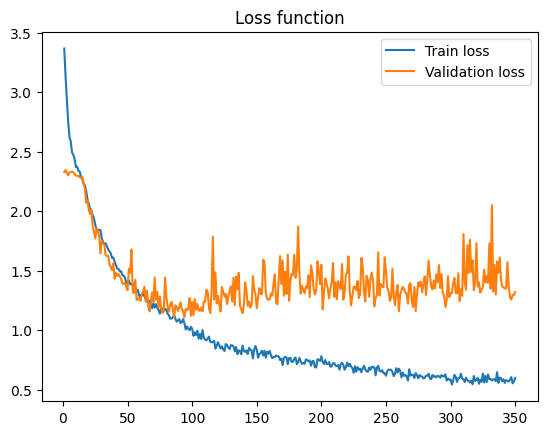

In [ ]:
##---------------------------------------------
##-------------- Loss evolution -----------
##---------------------------------------------
hist_cnn41 = history_cnn41.history
loss = hist_cnn41['loss']
val_loss = hist_cnn41['val_loss']
x = np.arange(350) + 1

plt.title("Loss function")
plt.plot(x, loss, label="Train loss")
plt.plot(x, val_loss, label="Validation loss")
plt.legend()
plt.show()

In [ ]:
##---------------------------------------------
##------------ Classification Report ----------
##---------------------------------------------
# CNN report and analysis
# es necesario que el  predict y el ytest esten en el mismo for, con eso garantizamos que ambos trabajen con el mismo conjunto de datos
from sklearn.metrics import confusion_matrix
from sklearn import metrics
yPred = np.array([])
yTest =  np.array([])
for x, y in valid_esc:
  yPred = np.concatenate([yPred, np.argmax(cnn41.predict(x), axis = -1)])
  yTest = np.concatenate([yTest, y.numpy()])  # no es necesario el argmax  aqui np.argmax(y.numpy(), axis=-1)
  
import numpy as np
#yPred = np.argmax(pred_Y, axis=1)
#yTest = valid_label  #np.argmax(test_label, axis=1) no es necesario por que nuestro test_label ya tiene la forma
labelNames =valid_dataset.class_names
cnn_f1 = metrics.f1_score(yTest, yPred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(yTest, yPred)
cnn_cm = metrics.confusion_matrix(yTest, yPred)
print("-------------------------------------------")
print("-----------------CNN Summary---------------")
print("-------------------------------------------")
print("CNN2 Trainning Time: {:0.2f} minute".format(cnn41_time/60.0))
print('Plotting confusion matrix')





1/1 [==============================] - 0s 33ms/step
-------------------------------------------
-----------------CNN Summary---------------
-------------------------------------------
CNN2 Trainning Time: 17.12 minute
Plotting confusion matrix


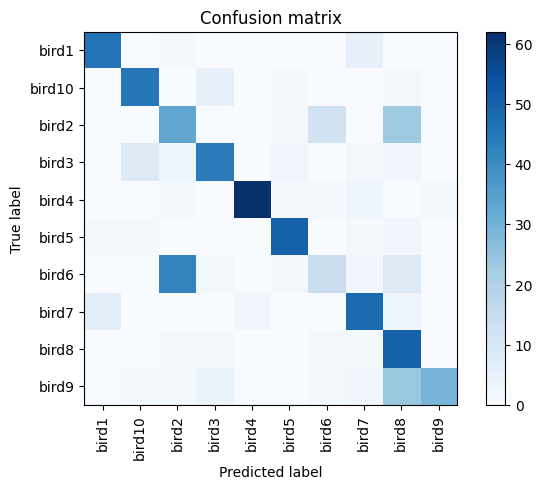

------------------------------------------------------------
----------------- Classification Report CNN ---------------
------------------------------------------------------------
              precision    recall  f1-score   support

       bird1       0.87      0.88      0.88        52
      bird10       0.82      0.87      0.84        52
       bird2       0.40      0.48      0.44        69
       bird3       0.80      0.73      0.77        60
       bird4       0.97      0.90      0.93        69
       bird5       0.89      0.91      0.90        55
       bird6       0.48      0.21      0.29        68
       bird7       0.76      0.81      0.79        59
       bird8       0.44      0.93      0.60        54
       bird9       0.97      0.47      0.63        62

    accuracy                           0.70       600
   macro avg       0.74      0.72      0.71       600
weighted avg       0.74      0.70      0.69       600



In [ ]:

plt.figure()
plot_confusion_matrix(cnn_cm, labelNames)
plt.show()
print("------------------------------------------------------------")
print("----------------- Classification Report CNN ---------------")
print("------------------------------------------------------------")
print(metrics.classification_report(yTest, yPred, target_names = labelNames))